In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-09-12 15:30:46 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-09-12 15:30:47 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-09-12 15:30:47 __main__ INFO     transformers.__version__='4.55.3'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
# model_key = "meta-llama/Llama-3.1-70B-Instruct"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-09-12 15:30:49 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks/checking_head_generalization, stdin=None, shell=False, universal_newlines=False)
2025-09-12 15:30:49 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks/checking_head_generalization, stdin=None, shell=False, universal_newlines=False)
2025-09-12 15:30:50 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-09-12 15:30:50 wandb.docker.auth DEBUG    No config file found


In [4]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-09-12 15:30:50 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-09-12 15:30:50 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-09-12 15:30:51 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-09-12 15:30:51 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-09-12 15:30:51 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/meta-llama/Llama-3.3-70B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-09-12 15:31:39 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-09-12 15:31:39 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-09-12 15:31:40 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [5]:
from src.selection.data import SelectOneTask, CountingTask

#################################################################################
TASK_CLS = SelectOneTask
prompt_template_idx = 3
# TASK_CLS = CountingTask
# prompt_template_idx = 1
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)

print(select_task)

SelectOneTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



In [6]:
sample = select_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=prompt_template_idx,
    # category="actor",
    # category="Brazil"
    category="fruit",
    filter_by_lm_prediction=False,
)

print(sample.prompt(), ">>", f'"{mt.tokenizer.decode([sample.ans_token_id])}"')

Options: Asparagus, Nightstand, Motorcycle, Headphones, Mirror, Mango.
Which among these objects mentioned above is a fruit?
Answer: >> " Mango"


## Loading the heads

2025-09-12 15:34:28 matplotlib DEBUG    matplotlib data path: /disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data
2025-09-12 15:34:28 matplotlib DEBUG    CONFIGDIR=/disk/u/arnab/.config/matplotlib
2025-09-12 15:34:28 matplotlib DEBUG    interactive is False
2025-09-12 15:34:28 matplotlib DEBUG    platform is linux
2025-09-12 15:34:28 matplotlib DEBUG    CACHEDIR=/disk/u/arnab/.cache/matplotlib
2025-09-12 15:34:28 matplotlib.font_manager DEBUG    Using fontManager instance from /disk/u/arnab/.cache/matplotlib/fontlist-v390.json
2025-09-12 15:34:28 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-09-12 15:34:28 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-09-12 15:34:28 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-09-12 15:34:28 matplotlib.font

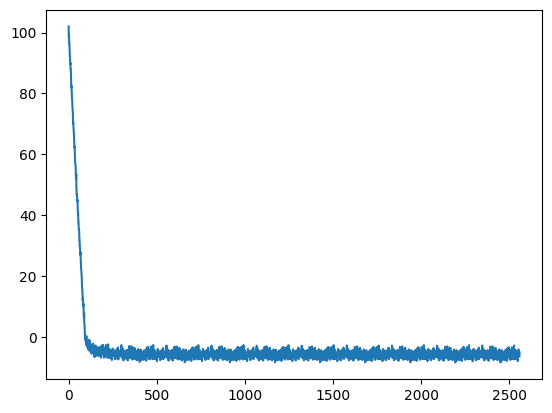

In [7]:
from matplotlib import pyplot as plt
import numpy as np

# optimized_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "selection/optimized_backup_heads",
#     mt.name.split("/")[-1],
#     f"{select_task.task_name}.npz"
# )

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/optimized_heads",
    model_key.split("/")[-1],
    "distinct_options",
    f"{select_task.task_name}",
    # "legacy",
    "epoch_10.npz"
)

# optimized_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "test_opt_code",
#     model_key.split("/")[-1],
#     "distinct_options",
#     f"{select_task.task_name}",
#     "legacy",
#     "epoch_10.npz"
# )

optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])
plt.show()

79


(True, True)

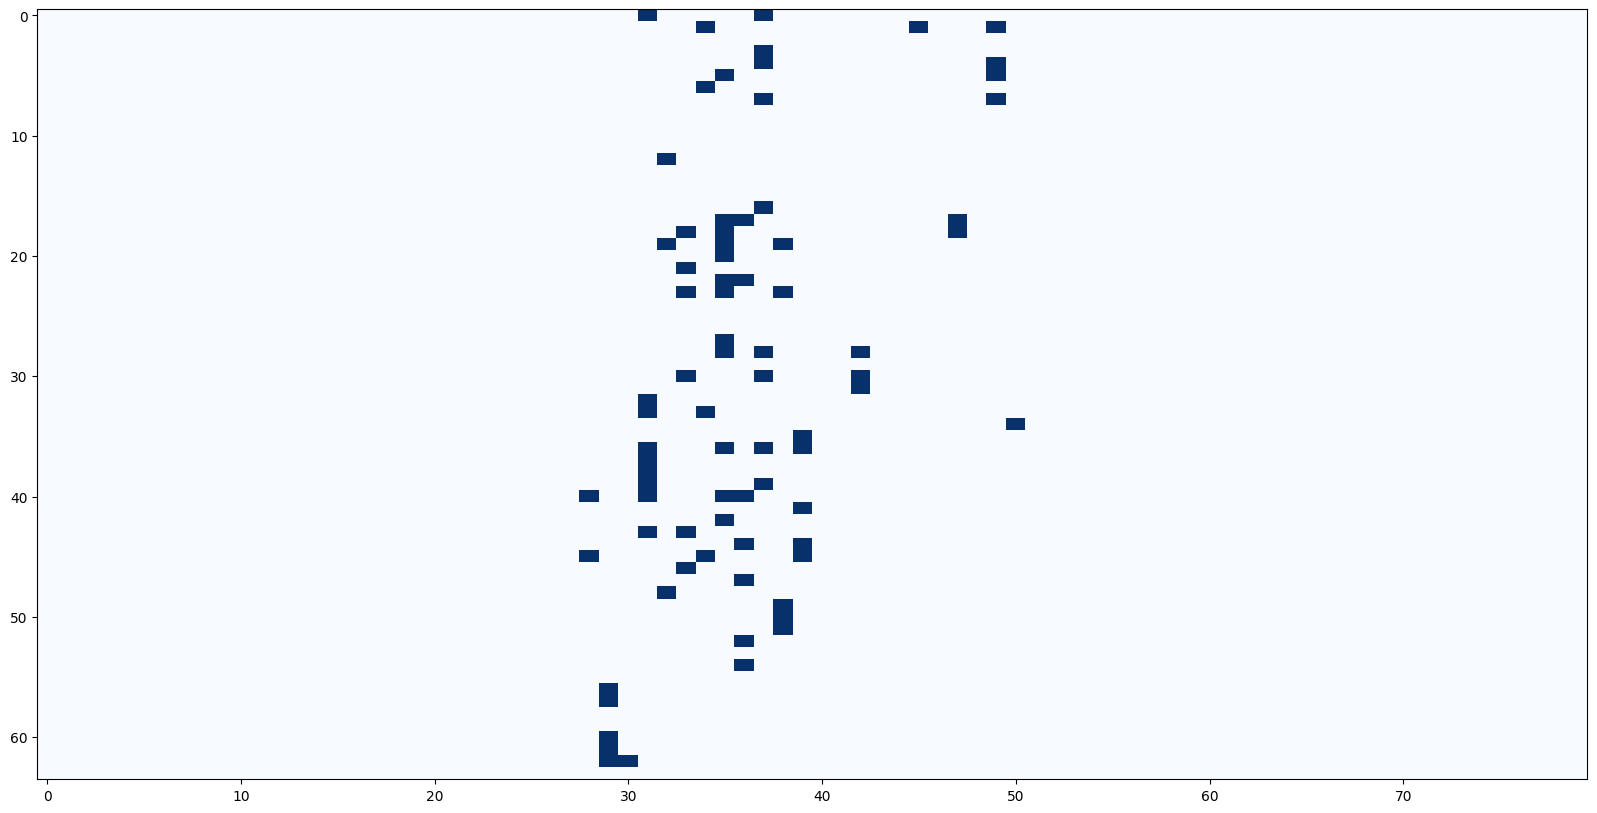

In [8]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[52:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

optimized_heads = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
optimized_heads = [
    (layer_idx, head_idx) for layer_idx, head_idx in optimized_heads
]
print(len(optimized_heads))

HEADS = optimized_heads

(35, 19) in HEADS, (35, 19) in optimized_heads
# [(29, 3) in HEADS]

In [9]:
from src.attention import get_attention_matrices
from src.selection.functional import (
    verify_head_patterns,
    get_patches_to_verify_independent_enrichment,
)

attn_pattern = verify_head_patterns(
    prompt=sample.prompt(option_style="single_line"),
    options=sample.options,
    mt=mt,
    heads=optimized_heads,
    # heads = HEADS,
    # heads = [(35, 19)],
    start_from=1
)

2025-09-12 15:34:33 src.selection.functional DEBUG    Predictions: ['" Mango"[91963] (p=0.781, logit=22.125)', '" The"[578] (p=0.106, logit=20.125)', '" Among"[22395] (p=0.050, logit=19.375)', '" A"[362] (p=0.034, logit=19.000)', '" M"[386] (p=0.003, logit=16.500)']
2025-09-12 15:34:33 src.selection.functional INFO     Combined attention matrix for all heads


# Validating Against Other Reduce Tasks

## SelectOne Task

In [10]:
from src.selection.data import SelectionSample, SelectOneTask

select_one_task = SelectOneTask.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        "objects.json"
        # "profession.json"
        # "nationality.json"
        # "landmarks.json"
    )
)
print(select_one_task)

SelectOneTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



In [11]:
test_sample = select_one_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=3,
    category="fruit",
    # category="actor",
    # category="United Kingdom",
    filter_by_lm_prediction=True,
)
print(test_sample.prompt(), ">>", f'"{mt.tokenizer.decode([test_sample.ans_token_id])}"')
test_sample.prediction

Options: Toothbrush, Anklet, Binder, Church, Flute, Raspberry.
Which among these objects mentioned above is a fruit?
Answer: >> " Raspberry"


[PredictedToken(token=' Raspberry', prob=0.7265625, logit=21.25, token_id=48665, metadata=None),
 PredictedToken(token=' The', prob=0.111328125, logit=19.375, token_id=578, metadata=None),
 PredictedToken(token=' Among', prob=0.0673828125, logit=18.875, token_id=22395, metadata=None),
 PredictedToken(token=' A', prob=0.0361328125, logit=18.25, token_id=362, metadata=None),
 PredictedToken(token=' R', prob=0.01171875, logit=17.125, token_id=432, metadata=None)]

In [12]:
attn_pattern = verify_head_patterns(
    prompt=test_sample.prompt(option_style="single_line"),
    options=test_sample.options,
    mt=mt,
    heads=optimized_heads,
    # heads = HEADS,
    # heads = [(35, 19)],
    start_from=1
)

2025-09-12 15:34:43 src.selection.functional DEBUG    Predictions: ['" Raspberry"[48665] (p=0.727, logit=21.250)', '" The"[578] (p=0.111, logit=19.375)', '" Among"[22395] (p=0.067, logit=18.875)', '" A"[362] (p=0.036, logit=18.250)', '" R"[432] (p=0.012, logit=17.125)']
2025-09-12 15:34:43 src.selection.functional INFO     Combined attention matrix for all heads


In [ ]:
from src.selection.data import CounterFactualSamplePair
from src.functional import free_gpu_cache
from src.selection.data import get_counterfactual_samples_interface
import random

validation_samples_save_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "validation",
    mt.name.split("/")[-1],
    select_one_task.task_name,
    "objects",
    # "profession",
    # "nationality",
    # "landmarks"
)

os.makedirs(validation_samples_save_path, exist_ok=True)


free_gpu_cache()
validation_set = []
validation_limit = 256

counterfactual_sampler = get_counterfactual_samples_interface[select_one_task.task_name]

while len(validation_set) < validation_limit:
    print(f"sample {len(validation_set)+1} / {validation_limit}")
    patch, clean = counterfactual_sampler(
        mt=mt,
        task=select_one_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=3,
        option_style=OPTION_STYLE,
        n_distractors=random.choice(range(2, 6)),
    )
    validation_set.append((clean, patch))
    cf_pair = CounterFactualSamplePair(
        patch_sample=patch,
        clean_sample=clean,
    )
    cf_pair.detensorize()
    with open(
        os.path.join(validation_samples_save_path, f"{len(validation_set):05d}.json"),
        "w",
    ) as f:
        json.dump(cf_pair.to_dict(), f, indent=2)

len(validation_set)

sample 1 / 256
2025-09-12 15:30:18 src.selection.data INFO     clean_obj_idx=0 | ['Stapler', 'Pear', 'Guitar']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-09-12 15:30:19 src.selection.data INFO     Options: Pen, Mushroom, Raspberry.
Which among these objects mentioned above is a fruit?
Answer:
2025-09-12 15:30:19 src.selection.data INFO     Mango | fruit -> Raspberry | pred=['" Raspberry"[48665] (p=0.863, logit=22.000)', '" The"[578] (p=0.043, logit=19.000)', '" Among"[22395] (p=0.026, logit=18.500)', '" R"[432] (p=0.008, logit=17.375)', '" A"[362] (p=0.008, logit=17.375)']
2025-09-12 15:30:19 src.selection.data INFO     Options: Stapler, Pear, Guitar.
Which among these objects mentioned above is a office supply?
Answer:
2025-09-12 15:30:19 src.selection.data INFO     Marker | office supply -> Stapler | pred=['" Stap"[63606] (p=0.738, logit=21.125)', '" The"[578] (p=0.113, logit=19.250)', '" A"[362] (p=0.068, logit=18.750)', '" Among"[22395] (p=0.020, logit=17.500)', '" 

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fab0ec29ad0>>
Traceback (most recent call last):
  File "/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


sample 6 / 256
2025-09-12 15:30:28 src.selection.data INFO     clean_obj_idx=2 | ['Train', 'Pepper', 'Theater', 'Helmet', 'Table']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-09-12 15:30:28 src.selection.data INFO     Options: Mango, Hospital, Spruce, Airplane, Recliner.
Which among these objects mentioned above is a vehicle?
Answer:
2025-09-12 15:30:28 src.selection.data INFO     Boat | vehicle -> Airplane | pred=['" Air"[6690] (p=0.730, logit=22.375)', '" An"[1556] (p=0.144, logit=20.750)', '" The"[578] (p=0.053, logit=19.750)', '" Among"[22395] (p=0.041, logit=19.500)', '" Spr"[15883] (p=0.004, logit=17.125)']
2025-09-12 15:30:28 src.selection.data INFO     Options: Train, Pepper, Theater, Helmet, Table.
Which among these objects mentioned above is a building?
Answer:
2025-09-12 15:30:28 src.selection.data INFO     Apartment | building -> Theater | pred=['" Theater"[38571] (p=0.836, logit=21.500)', '" The"[578] (p=0.061, logit=18.875)', '" Among"[22395] (p=0.032, logi

In [13]:
from src.selection.data import CounterFactualSamplePair
import random

validation_set = []
validation_limit = 1024

validation_samples_load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "validation",
    mt.name.split("/")[-1],
    select_one_task.task_name,
    "objects",
    # "profession",
    # "nationality"
    # "landmarks"
)

sample_files = [
    os.path.join(validation_samples_load_path, f)
    for f in os.listdir(validation_samples_load_path)
    if f.endswith(".json")
]
logger.info(f"Found {len(sample_files)} sample files")

random.shuffle(sample_files)
sample_files = sample_files[:validation_limit]
for sample_file in sample_files:
    with open(sample_file, "r") as f:
        cf_pair_data = json.load(f)
    cf_pair = CounterFactualSamplePair.from_dict(cf_pair_data)
    validation_set.append((cf_pair.clean_sample, cf_pair.patch_sample))

len(validation_set)

2025-09-12 15:35:00 __main__ INFO     Found 1024 sample files


1024

In [54]:
clean, patch = validation_set[3]
print(patch.prompt(), ">>", mt.tokenizer.decode(patch.ans_token_id))
print(clean.prompt(), ">>", mt.tokenizer.decode(clean.ans_token_id))
clean.metadata["track_type_obj_token_id"], mt.tokenizer.decode(clean.metadata["track_type_obj_token_id"])

Options: Onion, Pear, Sweater, Golf ball, Eraser, Router.
Which among these objects mentioned above is a electronics?
Answer: >>  Router
Options: Camera, Toilet paper, Blender, Bangle, Watermelon, Folder.
Which among these objects mentioned above is a fruit?
Answer: >>  Water


(14669, ' Camera')

In [ ]:
from src.selection.optimization import validate_q_proj_ie_on_sample_pair
import copy

clean, patch = copy.deepcopy(validation_set[5])
# failed_case = failed_pos_track["patch_obj_idx"][5]
# clean = failed_case["clean_sample"]
# patch = failed_case["patch_sample"]
# clean.default_option_style="numbered"
patch.default_option_style="numbered"

val_sample_result = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean,
    patch_sample=patch,
    heads=optimized_heads,
    query_indices={-2: -2, -1: -1},
    add_ques_pos_to_query_indices=True,
    verify_head_behavior_on=-1,
    patch_args={
        "batch_size": len(patch.options),
        "distinct_options": False,
        # "task": select_task,
        # "prompt_template_idx": prompt_template_idx,
        # "option_style": patch.default_option_style,
        # "n_distractors": N_DISTRACTORS,
    },
)

clean_obj = clean.ans_token_id
target_obj = clean.metadata["track_type_obj_token_id"]

logger.debug(f"clean obj: {mt.tokenizer.decode(clean_obj)}")
logger.debug(f"target obj: {mt.tokenizer.decode(target_obj)}")

before_intervention = {
    "clean_rank": val_sample_result["clean_track"][clean_obj][0],
    "clean_logit": val_sample_result["clean_track"][clean_obj][1].logit,
    "target_rank": val_sample_result["clean_track"][target_obj][0],
    "target_logit": val_sample_result["clean_track"][target_obj][1].logit,
}

after_intervention = {
    "clean_rank": val_sample_result["int_track"][clean_obj][0],
    "clean_logit": val_sample_result["int_track"][clean_obj][1].logit,
    "target_rank": val_sample_result["int_track"][target_obj][0],
    "target_logit": val_sample_result["int_track"][target_obj][1].logit,
}

clean_rank_delta = after_intervention["clean_rank"] - before_intervention["clean_rank"]
target_rank_delta = (
    after_intervention["target_rank"] - before_intervention["target_rank"]
)
logger.info(
    f"Clean Prediction Rank Change: {before_intervention['clean_rank']} -> {after_intervention['clean_rank']} | Delta: {clean_rank_delta} "
)
logger.info(
    f"Target Prediction Rank Change: {before_intervention['target_rank']} -> {after_intervention['target_rank']} | Delta: {target_rank_delta} "
)

clean_logit_delta = (
    after_intervention["clean_logit"] - before_intervention["clean_logit"]
)
target_logit_delta = (
    after_intervention["target_logit"] - before_intervention["target_logit"]
)
logger.info(
    f"Clean Prediction Logit Change: {before_intervention['clean_logit']:.4f} -> {after_intervention['clean_logit']:.4f} | Delta: {clean_logit_delta:.4f} "
)
logger.info(
    f"Target Prediction Logit Change: {before_intervention['target_logit']:.4f} -> {after_intervention['target_logit']:.4f} | Delta: {target_logit_delta:.4f} "
)

2025-09-11 23:17:38 src.selection.optimization DEBUG    Sampling 4 patch samples...
2025-09-11 23:17:39 src.selection.optimization DEBUG    torch.Size([4, 33])
2025-09-11 23:17:39 src.selection.optimization INFO     Verifying head behavior...
2025-09-11 23:17:39 src.selection.optimization INFO     Clean Sample >> Ans:  Pressure


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-09-11 23:17:43 src.selection.functional DEBUG    Generated full answer: " Pressure cooker. A pressure cooker is a kitchen appliance used for cooking food quickly and efficiently. It works by using steam pressure to cook food faster than traditional"
2025-09-11 23:17:43 src.selection.functional DEBUG    Predictions: ['" Pressure"[40090] (p=0.824, logit=22.000)', '" The"[578] (p=0.047, logit=19.125)', '" Among"[22395] (p=0.047, logit=19.125)', '" A"[362] (p=0.036, logit=18.875)', '" Option"[7104] (p=0.008, logit=17.375)']
2025-09-11 23:17:43 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-11 23:17:43 src.selection.optimization INFO     Patch Sample >> Ans:  Hick


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-09-11 23:17:47 src.selection.functional DEBUG    Generated full answer: " c. Hickory
Explanation: Hickory is a type of tree, specifically a deciduous tree native to North America. The other options are not"
2025-09-11 23:17:47 src.selection.functional DEBUG    Predictions: ['" c"[272] (p=0.715, logit=21.125)', '" Hick"[79028] (p=0.097, logit=19.125)', '" ("[320] (p=0.085, logit=19.000)', '" The"[578] (p=0.040, logit=18.250)', '" Option"[7104] (p=0.017, logit=17.375)']
2025-09-11 23:17:47 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-11 23:17:47 src.selection.optimization INFO     Caching the query states for the 79 heads
2025-09-11 23:17:48 src.selection.optimization INFO     patch_prediction=['" c"[272] (p=0.715, logit=21.125)', '" Hick"[79028] (p=0.097, logit=19.125)', '" ("[320] (p=0.085, logit=19.000)', '" The"[578] (p=0.040, logit=18.250)', '" Option"[7104] (p=0.017, logit=17.375)']
2025-09-11 23:17:48 src.selection.optimization INFO     clean run
2025-09-11 23:17:48 src.selection.optimization INFO     clean_prediction=['" Pressure"[40090] (p=0.824, logit=22.000)', '" Among"[22395] (p=0.047, logit=19.125)', '" The"[578] (p=0.047, logit=19.125)', '" A"[362] (p=0.036, logit=18.875)', '" Option"[7104] (p=0.008, logit=17.375)']
2025-09-11 23:17:48 src.selection.optimization INFO     clean_track=OrderedDict([(40090, (1, PredictedToken(token=' Pressure', prob=0.82421875, logit=22.0, token_id=40090, metadata=None))), (42609, (44, PredictedToken(token=' Pine', prob=9.012222290039062e-05, logit=12.875, token_i

2025-09-11 23:17:48 src.selection.optimization INFO     int_prediction=['" Willow"[65449] (p=0.645, logit=20.375)', '" Among"[22395] (p=0.112, logit=18.625)', '" The"[578] (p=0.087, logit=18.375)', '" Pine"[42609] (p=0.041, logit=17.625)', '" Option"[7104] (p=0.032, logit=17.375)']
2025-09-11 23:17:48 src.selection.optimization INFO     int_track=OrderedDict([(65449, (1, PredictedToken(token=' Willow', prob=0.64453125, logit=20.375, token_id=65449, metadata=None))), (42609, (4, PredictedToken(token=' Pine', prob=0.041259765625, logit=17.625, token_id=42609, metadata=None))), (40090, (31, PredictedToken(token=' Pressure', prob=0.00070953369140625, logit=13.5625, token_id=40090, metadata=None))), (68027, (298, PredictedToken(token=' Sax', prob=7.3909759521484375e-06, logit=9.0, token_id=68027, metadata=None)))])
2025-09-11 23:17:48 __main__ DEBUG    clean obj:  Pressure
2025-09-11 23:17:48 __main__ DEBUG    target obj:  Willow
2025-09-11 23:17:48 __main__ INFO     Clean Prediction Rank C

In [56]:
from tqdm.auto import tqdm

validation_results = []

for clean_sample, patch_sample in tqdm(validation_set):
    patch_sample.default_option_style="numbered"
    val_sample_result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        heads=optimized_heads,
        query_indices={-2: -2, -1: -1},
        add_ques_pos_to_query_indices=True,
        # patch_args={
        #     "batch_size": len(patch.options),
        #     "task": select_task,
        #     "prompt_template_idx": prompt_template_idx,
        #     "option_style": patch.default_option_style,
        #     "distinct_options": False,
        #     "n_distractors": N_DISTRACTORS,
        # },
    )
    validation_results.append(val_sample_result)
    print("=" * 80)

  0%|          | 0/1024 [00:00<?, ?it/s]

2025-09-11 23:18:09 src.selection.optimization INFO     Caching the query states for the 79 heads
2025-09-11 23:18:10 src.selection.optimization INFO     patch_prediction=['" d"[294] (p=0.613, logit=21.875)', '" ("[320] (p=0.155, logit=20.500)', '" Option"[7104] (p=0.065, logit=19.625)', '" Tr"[1183] (p=0.057, logit=19.500)', '" The"[578] (p=0.051, logit=19.375)']
2025-09-11 23:18:10 src.selection.optimization INFO     clean run


2025-09-11 23:18:10 src.selection.optimization INFO     clean_prediction=['" C"[356] (p=0.750, logit=21.750)', '" The"[578] (p=0.079, logit=19.500)', '" Among"[22395] (p=0.070, logit=19.375)', '" A"[362] (p=0.037, logit=18.750)', '" It"[1102] (p=0.007, logit=17.125)']
2025-09-11 23:18:10 src.selection.optimization INFO     clean_track=OrderedDict([(356, (1, PredictedToken(token=' C', prob=0.75, logit=21.75, token_id=356, metadata=None))), (22607, (18, PredictedToken(token=' Cow', prob=0.00099945068359375, logit=15.125, token_id=22607, metadata=None))), (30760, (34, PredictedToken(token=' Scar', prob=0.0003452301025390625, logit=14.0625, token_id=30760, metadata=None))), (38930, (85, PredictedToken(token=' Bike', prob=3.8623809814453125e-05, logit=11.875, token_id=38930, metadata=None)))])
2025-09-11 23:18:10 src.selection.optimization INFO     patching the q_proj states
2025-09-11 23:18:10 src.selection.optimization INFO     int_prediction=['" Bike"[38930] (p=0.859, logit=21.625)', '" 

In [57]:
before_intervention = []
after_intervention = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    before_intervention.append({
        "clean_rank": intervention_result["clean_track"][clean_obj][0],
        "clean_logit": intervention_result["clean_track"][clean_obj][1].logit,
        "target_rank": intervention_result["clean_track"][target_obj][0],
        "target_logit": intervention_result["clean_track"][target_obj][1].logit,
    })

    after_intervention.append({
        "clean_rank": intervention_result["int_track"][clean_obj][0],
        "clean_logit": intervention_result["int_track"][clean_obj][1].logit,
        "target_rank": intervention_result["int_track"][target_obj][0],
        "target_logit": intervention_result["int_track"][target_obj][1].logit,
    })

In [58]:
import numpy as np

clean_rank_delta = [
    after["clean_rank"] - before["clean_rank"]
    for before, after in zip(before_intervention, after_intervention)
]
target_rank_delta = [
    after["target_rank"] - before["target_rank"]
    for before, after in zip(before_intervention, after_intervention)
]

clean_rank_delta, target_rank_delta = np.array(clean_rank_delta), np.array(
    target_rank_delta
)
print(f"clean_rank_delta: {clean_rank_delta.mean():.4f} ± {clean_rank_delta.std():.4f}")
print(
    f"target_rank_delta: {target_rank_delta.mean():.4f} ± {target_rank_delta.std():.4f}"
)

clean_rank_after_intervention = [after["clean_rank"] for after in after_intervention]
clean_rank_after_intervention = np.array(clean_rank_after_intervention)
print(
    f"clean_rank_after_intervention: {clean_rank_after_intervention.mean():.4f} ± {clean_rank_after_intervention.std():.4f}"
)

target_rank_after_intervention = [after["target_rank"] for after in after_intervention]
target_rank_after_intervention = np.array(target_rank_after_intervention)
print(
    f"target_rank_after_intervention: {target_rank_after_intervention.mean():.4f} ± {target_rank_after_intervention.std():.4f}"
)

clean_rank_delta: 63.1885 ± 181.0540
target_rank_delta: -155.6299 ± 362.4775
clean_rank_after_intervention: 64.1924 ± 181.0527
target_rank_after_intervention: 2.1729 ± 4.8267


In [59]:
clean_logit_delta = [
    after["clean_logit"] - before["clean_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
target_logit_delta = [
    after["target_logit"] - before["target_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
clean_logit_delta, target_logit_delta = np.array(clean_logit_delta), np.array(target_logit_delta)
print(f"clean_logit_delta: {clean_logit_delta.mean():.4f} ± {clean_logit_delta.std():.4f}")
print(f"target_logit_delta: {target_logit_delta.mean():.4f} ± {target_logit_delta.std():.4f}")

clean_logit_after_intervention = [
    after["clean_logit"]
    for after in after_intervention
]
clean_logit_after_intervention = np.array(clean_logit_after_intervention)
print(f"clean_logit_after_intervention: {clean_logit_after_intervention.mean():.4f} ± {clean_logit_after_intervention.std():.4f}")

target_logit_after_intervention = [
    after["target_logit"]
    for after in after_intervention
]
target_logit_after_intervention = np.array(target_logit_after_intervention)
print(f"target_logit_after_intervention: {target_logit_after_intervention.mean():.4f} ± {target_logit_after_intervention.std():.4f}")

clean_logit_delta: -6.4951 ± 3.4991
target_logit_delta: 7.9606 ± 3.2262
clean_logit_after_intervention: 15.1983 ± 3.4787
target_logit_after_intervention: 20.4417 ± 1.8577


In [60]:
top_1 = sum([1 for after in after_intervention if after["target_rank"] == 1])
top_1 / len(after_intervention)

0.7734375

In [61]:
counter_patch_type_top_option = 0
failed_cases = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]
    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"]
    ): 
        counter_patch_type_top_option += 1
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
            }
        )

top_1_accuracy = counter_patch_type_top_option / len(validation_results)
print("=" * 80)
print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f} ({counter_patch_type_top_option}/{len(validation_results)})"
)
print("=" * 80)
print(f"{len(failed_cases)}")

Counterfactual patching accuracy: 0.7793 (798/1024)
226


In [23]:
for failed_case in failed_cases:
    clean_sample = failed_case["clean_sample"]
    patch_sample = failed_case["patch_sample"]
    int_track = failed_case["int_track"]
    clean_track = failed_case["clean_track"]

    print("Clean Sample:")
    print(clean_sample.prompt(), ">>", f'"{mt.tokenizer.decode([clean_sample.ans_token_id])}"')

    print("-" * 100)
    print(
        "Track: ",
        " | Token"
        f"\"{mt.tokenizer.decode(clean_sample.metadata['track_type_obj_token_id'])}\"",
    )
    print("Clean:", f"(Token: {mt.tokenizer.decode(clean_sample.ans_token_id)})")
    print("-" * 100)

    clean_track = [pred for tok_id, (rank, pred) in clean_track.items()]
    print(f"Clean Track: {json.dumps([str(pred) for pred in clean_track], indent=4)}")

    int_track = [pred for tok_id, (rank, pred) in int_track.items()]
    print(
        f"Intervened Track: {json.dumps([str(pred) for pred in int_track], indent=4)}"
    )
    print("=" * 100)

Clean Sample:
Options: Oriental Pearl Tower, Sphinx, Sydney Opera House.
Which of these landmarks is in Australia?
Answer: >> " Sydney"
----------------------------------------------------------------------------------------------------
Track:   | Token" Oriental"
Clean: (Token:  Sydney)
----------------------------------------------------------------------------------------------------
Clean Track: [
    "\" Sydney\"[21972] (p=0.867, logit=22.625)",
    "\" Oriental\"[72051] (p=0.001, logit=15.188)",
    "\" Sphinx\"[95293] (p=0.000, logit=11.312)"
]
Intervened Track: [
    "\" Sydney\"[21972] (p=0.660, logit=21.625)",
    "\" Oriental\"[72051] (p=0.130, logit=20.000)",
    "\" Sphinx\"[95293] (p=0.000, logit=11.312)"
]
Clean Sample:
Options: Geirangerfjord, Bondi Beach, Cabo da Roca, Egyptian Museum, Plaza de España (Seville).
Which of these landmarks is in Egypt?
Answer: >> " Egyptian"
--------------------------------------------------------------------------------------------------

In [24]:
#! find the positions after the patched intervention.
# Is it looking at the first one, or the position of the 
# previous answer?

from src.selection.utils import get_first_token_id

failed_pos_track = {
    "clean_obj_idx": [],
    "patch_obj_idx": [],
    "first_obj_idx": [],
    "other": []
}

for failed_case in failed_cases:
    clean_sample = failed_case["clean_sample"]
    patch_sample = failed_case["patch_sample"]
    int_track = failed_case["int_track"]
    clean_track = failed_case["clean_track"]
    clean_obj_idx = clean_sample.obj_idx
    patch_obj_idx = patch_sample.obj_idx

    int_top_tok = list(int_track.keys())[0]
    int_top_obj = int_track[int_top_tok][1].token_id
    opt_first_tokens = [
        get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
        for opt in clean_sample.options
    ]
    int_top_idx = opt_first_tokens.index(int_top_obj)

    if int_top_idx == clean_obj_idx:
        failed_pos_track["clean_obj_idx"].append(failed_case)
    elif int_top_idx == patch_obj_idx:
        failed_pos_track["patch_obj_idx"].append(failed_case)
    elif int_top_idx == 0:
        failed_pos_track["first_obj_idx"].append(failed_case)
    else:
        failed_pos_track["other"].append(failed_case)


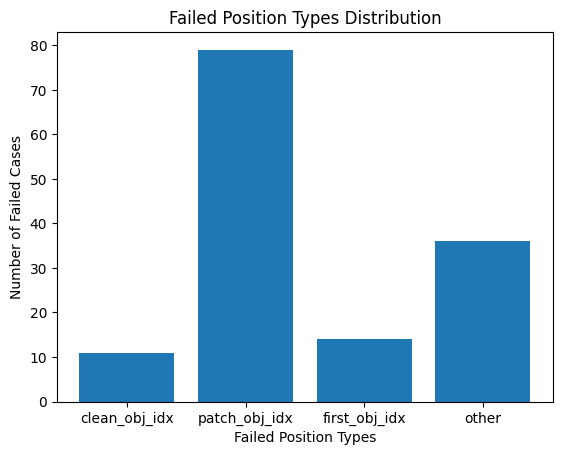

In [26]:
from matplotlib import pyplot as plt
x_vals = failed_pos_track.keys()
y_vals = [len(failed_pos_track[key]) for key in x_vals]
plt.bar(x_vals, y_vals)
plt.xlabel("Failed Position Types")
plt.ylabel("Number of Failed Cases")
plt.title("Failed Position Types Distribution")
plt.show()

## Select One -- MCQ

In [14]:
from src.selection.data import SelectionSample, SelectOneTask

select_one_mcq = SelectOneTask.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        "objects.json"
        # "profession.json"
        # "nationality.json"
        # "landmarks.json"
    )
)
print(select_one_task)

SelectOneTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



In [28]:
import copy
from src.selection.utils import get_first_token_id
from src.functional import predict_next_token

def MCQify_sample(sample: SelectionSample) -> SelectionSample:
    sample = copy.deepcopy(sample)
    sample.default_option_style = "numbered"
    correct_option = chr(ord('a') + sample.obj_idx)
    sample.ans_token_id = get_first_token_id(
        name=correct_option,
        tokenizer=mt.tokenizer,
        prefix=" "
    )
    sample.metadata["question_type"] = "MCQ"
    return sample

test_sample = select_one_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=3,
    category="fruit",
    # category="actor",
    # category="United Kingdom",
    filter_by_lm_prediction=True,
)

test_sample = MCQify_sample(test_sample)
print(test_sample.prompt(), ">>", f'"{mt.tokenizer.decode([test_sample.ans_token_id])}"')

predict_next_token(
    mt = mt,
    inputs = test_sample.prompt()
)

a. Monitor
b. Scooter
c. Grape
d. House
e. Cat
f. Mushroom
Which among these objects mentioned above is a fruit?
Answer: >> " c"


[[PredictedToken(token=' c', prob=0.69921875, logit=21.375, token_id=272, metadata=None),
  PredictedToken(token=' (', prob=0.15625, logit=19.875, token_id=320, metadata=None),
  PredictedToken(token=' Grape', prob=0.03955078125, logit=18.5, token_id=80629, metadata=None),
  PredictedToken(token=' Option', prob=0.027099609375, logit=18.125, token_id=7104, metadata=None),
  PredictedToken(token=' The', prob=0.02392578125, logit=18.0, token_id=578, metadata=None)]]

In [29]:
attn_pattern = verify_head_patterns(
    prompt=test_sample.prompt(),
    options=test_sample.options,
    mt=mt,
    heads=optimized_heads,
    # heads = HEADS,
    # heads = [(35, 19)],
    start_from=1
)

2025-09-12 17:54:51 src.selection.functional DEBUG    Predictions: ['" c"[272] (p=0.699, logit=21.375)', '" ("[320] (p=0.156, logit=19.875)', '" Grape"[80629] (p=0.040, logit=18.500)', '" Option"[7104] (p=0.027, logit=18.125)', '" The"[578] (p=0.024, logit=18.000)']
2025-09-12 17:54:51 src.selection.functional INFO     Combined attention matrix for all heads


In [37]:
from src.selection.data import CounterFactualSamplePair
import random

validation_set = []
validation_limit = 1024

validation_samples_load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "validation",
    mt.name.split("/")[-1],
    select_one_task.task_name,
    "objects",
    # "profession",
    # "nationality"
    # "landmarks"
)

sample_files = [
    os.path.join(validation_samples_load_path, f)
    for f in os.listdir(validation_samples_load_path)
    if f.endswith(".json")
]
logger.info(f"Found {len(sample_files)} sample files")

random.shuffle(sample_files)
sample_files = sample_files[:validation_limit]
for sample_file in sample_files:
    with open(sample_file, "r") as f:
        cf_pair_data = json.load(f)
    cf_pair = CounterFactualSamplePair.from_dict(cf_pair_data)
    pred_target_token_id = cf_pair.clean_sample.metadata["track_type_obj_token_id"]
    pred_obj_idx = cf_pair.clean_sample.metadata["track_type_obj_idx"]
    cf_pair.clean_sample.metadata["track_type_obj_token_id"] = get_first_token_id(
        name=chr(ord('a') + pred_obj_idx),
        tokenizer=mt.tokenizer,
        prefix=" "
    )
    validation_set.append((
        MCQify_sample(cf_pair.clean_sample), 
        MCQify_sample(cf_pair.patch_sample)
    ))

len(validation_set)

2025-09-12 18:02:28 __main__ INFO     Found 1024 sample files


1024

In [38]:
clean, patch = validation_set[3]
print(patch.prompt(), ">>", mt.tokenizer.decode(patch.ans_token_id))
print(clean.prompt(), ">>", mt.tokenizer.decode(clean.ans_token_id))
clean.metadata["track_type_obj_token_id"], mt.tokenizer.decode(clean.metadata["track_type_obj_token_id"])

a. Television
b. Towel
c. Mushroom
d. Violin
e. Basketball
f. Raspberry
Which among these objects mentioned above is a electronics?
Answer: >>  a
a. Shower
b. Phone
c. Violet
d. Lettuce
e. Oven
f. Jeans
Which among these objects mentioned above is a vegetable?
Answer: >>  d


(293, ' b')

In [39]:
from src.selection.optimization import validate_q_proj_ie_on_sample_pair
import copy

clean, patch = copy.deepcopy(validation_set[5])
# failed_case = failed_pos_track["patch_obj_idx"][5]
# clean = failed_case["clean_sample"]
# patch = failed_case["patch_sample"]
# clean.default_option_style="numbered"
patch.default_option_style="numbered"

val_sample_result = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean,
    patch_sample=patch,
    heads=optimized_heads,
    query_indices={-2: -2, -1: -1},
    add_ques_pos_to_query_indices=True,
    verify_head_behavior_on=-1,
    patch_args={
        "batch_size": len(patch.options),
        "distinct_options": False,
        # "task": select_task,
        # "prompt_template_idx": prompt_template_idx,
        # "option_style": patch.default_option_style,
        # "n_distractors": N_DISTRACTORS,
    },
)

clean_obj = clean.ans_token_id
target_obj = clean.metadata["track_type_obj_token_id"]

logger.debug(f"clean obj: {mt.tokenizer.decode(clean_obj)}")
logger.debug(f"target obj: {mt.tokenizer.decode(target_obj)}")

before_intervention = {
    "clean_rank": val_sample_result["clean_track"][clean_obj][0],
    "clean_logit": val_sample_result["clean_track"][clean_obj][1].logit,
    "target_rank": val_sample_result["clean_track"][target_obj][0],
    "target_logit": val_sample_result["clean_track"][target_obj][1].logit,
}

after_intervention = {
    "clean_rank": val_sample_result["int_track"][clean_obj][0],
    "clean_logit": val_sample_result["int_track"][clean_obj][1].logit,
    "target_rank": val_sample_result["int_track"][target_obj][0],
    "target_logit": val_sample_result["int_track"][target_obj][1].logit,
}

clean_rank_delta = after_intervention["clean_rank"] - before_intervention["clean_rank"]
target_rank_delta = (
    after_intervention["target_rank"] - before_intervention["target_rank"]
)
logger.info(
    f"Clean Prediction Rank Change: {before_intervention['clean_rank']} -> {after_intervention['clean_rank']} | Delta: {clean_rank_delta} "
)
logger.info(
    f"Target Prediction Rank Change: {before_intervention['target_rank']} -> {after_intervention['target_rank']} | Delta: {target_rank_delta} "
)

clean_logit_delta = (
    after_intervention["clean_logit"] - before_intervention["clean_logit"]
)
target_logit_delta = (
    after_intervention["target_logit"] - before_intervention["target_logit"]
)
logger.info(
    f"Clean Prediction Logit Change: {before_intervention['clean_logit']:.4f} -> {after_intervention['clean_logit']:.4f} | Delta: {clean_logit_delta:.4f} "
)
logger.info(
    f"Target Prediction Logit Change: {before_intervention['target_logit']:.4f} -> {after_intervention['target_logit']:.4f} | Delta: {target_logit_delta:.4f} "
)

2025-09-12 18:02:41 src.selection.optimization DEBUG    Sampling 3 patch samples...
2025-09-12 18:02:41 src.selection.optimization DEBUG    torch.Size([3, 28])
2025-09-12 18:02:41 src.selection.optimization INFO     Verifying head behavior...
2025-09-12 18:02:41 src.selection.optimization INFO     Clean Sample >> Ans:  b


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-09-12 18:02:45 src.selection.functional DEBUG    Generated full answer: " b. Projector
Explanation: A projector is an electronic device that projects images or videos onto a screen or surface. It is commonly used in presentations"
2025-09-12 18:02:45 src.selection.functional DEBUG    Predictions: ['" b"[293] (p=0.801, logit=20.750)', '" ("[320] (p=0.045, logit=17.875)', '" Project"[5907] (p=0.027, logit=17.375)', '" The"[578] (p=0.027, logit=17.375)', '" Option"[7104] (p=0.021, logit=17.125)']
2025-09-12 18:02:45 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-12 18:02:45 src.selection.optimization INFO     Patch Sample >> Ans:  a


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-09-12 18:02:49 src.selection.functional DEBUG    Generated full answer: " a. Folder
Explanation: A folder is a common office supply used to store and organize documents. It is a type of container made of paper or"
2025-09-12 18:02:49 src.selection.functional DEBUG    Predictions: ['" a"[264] (p=0.820, logit=21.875)', '" ("[320] (p=0.036, logit=18.750)', '" A"[362] (p=0.032, logit=18.625)', '" Folder"[36943] (p=0.028, logit=18.500)', '" The"[578] (p=0.022, logit=18.250)']
2025-09-12 18:02:49 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-12 18:02:49 src.selection.optimization INFO     Caching the query states for the 79 heads
2025-09-12 18:02:50 src.selection.optimization INFO     patch_prediction=['" a"[264] (p=0.820, logit=21.875)', '" ("[320] (p=0.036, logit=18.750)', '" A"[362] (p=0.032, logit=18.625)', '" Folder"[36943] (p=0.028, logit=18.500)', '" The"[578] (p=0.022, logit=18.250)']
2025-09-12 18:02:50 src.selection.optimization INFO     clean run
2025-09-12 18:02:50 src.selection.optimization INFO     clean_prediction=['" b"[293] (p=0.801, logit=20.750)', '" ("[320] (p=0.045, logit=17.875)', '" The"[578] (p=0.027, logit=17.375)', '" Project"[5907] (p=0.027, logit=17.375)', '" Option"[7104] (p=0.021, logit=17.125)']
2025-09-12 18:02:50 src.selection.optimization INFO     clean_track=OrderedDict([(293, (1, PredictedToken(token=' b', prob=0.80078125, logit=20.75, token_id=293, metadata=None))), (264, (7, PredictedToken(token=' a', prob=0.01141357421875, logit=16.5, token_id=264, metadata=None))), (272, (14,

2025-09-12 18:02:50 src.selection.optimization INFO     int_prediction=['" c"[272] (p=0.758, logit=20.750)', '" ("[320] (p=0.062, logit=18.250)', '" Pen"[13597] (p=0.062, logit=18.250)', '" C"[356] (p=0.026, logit=17.375)', '" Option"[7104] (p=0.016, logit=16.875)']
2025-09-12 18:02:50 src.selection.optimization INFO     int_track=OrderedDict([(272, (1, PredictedToken(token=' c', prob=0.7578125, logit=20.75, token_id=272, metadata=None))), (264, (7, PredictedToken(token=' a', prob=0.01080322265625, logit=16.5, token_id=264, metadata=None))), (293, (8, PredictedToken(token=' b', prob=0.01080322265625, logit=16.5, token_id=293, metadata=None)))])
2025-09-12 18:02:50 __main__ DEBUG    clean obj:  b
2025-09-12 18:02:50 __main__ DEBUG    target obj:  c
2025-09-12 18:02:50 __main__ INFO     Clean Prediction Rank Change: 1 -> 8 | Delta: 7 
2025-09-12 18:02:50 __main__ INFO     Target Prediction Rank Change: 14 -> 1 | Delta: -13 
2025-09-12 18:02:50 __main__ INFO     Clean Prediction Logit Cha

In [41]:
from tqdm.auto import tqdm

validation_results = []

for clean_sample, patch_sample in tqdm(validation_set):
    patch_sample.default_option_style="numbered"
    val_sample_result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        heads=optimized_heads,
        query_indices={-2: -2, -1: -1},
        add_ques_pos_to_query_indices=True,
        patch_args={
            "batch_size": len(patch.options),
            "distinct_options": False,
            # "task": select_task,
            # "prompt_template_idx": prompt_template_idx,
            # "option_style": patch.default_option_style,
            # "n_distractors": N_DISTRACTORS,
        },
    )
    validation_results.append(val_sample_result)
    print("=" * 80)

  0%|          | 0/1024 [00:00<?, ?it/s]

2025-09-12 18:04:56 src.selection.optimization DEBUG    Sampling 3 patch samples...


2025-09-12 18:04:56 src.selection.optimization DEBUG    torch.Size([3, 33])
2025-09-12 18:04:56 src.selection.optimization INFO     Caching the query states for the 79 heads
2025-09-12 18:04:56 src.selection.optimization INFO     patch_prediction=['" d"[294] (p=0.746, logit=21.250)', '" ("[320] (p=0.130, logit=19.500)', '" The"[578] (p=0.029, logit=18.000)', '" Option"[7104] (p=0.026, logit=17.875)', '" A"[362] (p=0.016, logit=17.375)']
2025-09-12 18:04:56 src.selection.optimization INFO     clean run
2025-09-12 18:04:56 src.selection.optimization INFO     clean_prediction=['" c"[272] (p=0.805, logit=22.000)', '" ("[320] (p=0.109, logit=20.000)', '" Tul"[43316] (p=0.024, logit=18.500)', '" The"[578] (p=0.021, logit=18.375)', '" Option"[7104] (p=0.015, logit=18.000)']
2025-09-12 18:04:56 src.selection.optimization INFO     clean_track=OrderedDict([(272, (1, PredictedToken(token=' c', prob=0.8046875, logit=22.0, token_id=272, metadata=None))), (264, (8, PredictedToken(token=' a', prob=0.

In [42]:
before_intervention = []
after_intervention = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    before_intervention.append({
        "clean_rank": intervention_result["clean_track"][clean_obj][0],
        "clean_logit": intervention_result["clean_track"][clean_obj][1].logit,
        "target_rank": intervention_result["clean_track"][target_obj][0],
        "target_logit": intervention_result["clean_track"][target_obj][1].logit,
    })

    after_intervention.append({
        "clean_rank": intervention_result["int_track"][clean_obj][0],
        "clean_logit": intervention_result["int_track"][clean_obj][1].logit,
        "target_rank": intervention_result["int_track"][target_obj][0],
        "target_logit": intervention_result["int_track"][target_obj][1].logit,
    })

In [43]:
import numpy as np

clean_rank_delta = [
    after["clean_rank"] - before["clean_rank"]
    for before, after in zip(before_intervention, after_intervention)
]
target_rank_delta = [
    after["target_rank"] - before["target_rank"]
    for before, after in zip(before_intervention, after_intervention)
]

clean_rank_delta, target_rank_delta = np.array(clean_rank_delta), np.array(
    target_rank_delta
)
print(f"clean_rank_delta: {clean_rank_delta.mean():.4f} ± {clean_rank_delta.std():.4f}")
print(
    f"target_rank_delta: {target_rank_delta.mean():.4f} ± {target_rank_delta.std():.4f}"
)

clean_rank_after_intervention = [after["clean_rank"] for after in after_intervention]
clean_rank_after_intervention = np.array(clean_rank_after_intervention)
print(
    f"clean_rank_after_intervention: {clean_rank_after_intervention.mean():.4f} ± {clean_rank_after_intervention.std():.4f}"
)

target_rank_after_intervention = [after["target_rank"] for after in after_intervention]
target_rank_after_intervention = np.array(target_rank_after_intervention)
print(
    f"target_rank_after_intervention: {target_rank_after_intervention.mean():.4f} ± {target_rank_after_intervention.std():.4f}"
)

clean_rank_delta: 15.3154 ± 14.1031
target_rank_delta: -12.0020 ± 9.2156
clean_rank_after_intervention: 16.3555 ± 14.1022
target_rank_after_intervention: 1.8340 ± 2.6287


In [44]:
clean_logit_delta = [
    after["clean_logit"] - before["clean_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
target_logit_delta = [
    after["target_logit"] - before["target_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
clean_logit_delta, target_logit_delta = np.array(clean_logit_delta), np.array(target_logit_delta)
print(f"clean_logit_delta: {clean_logit_delta.mean():.4f} ± {clean_logit_delta.std():.4f}")
print(f"target_logit_delta: {target_logit_delta.mean():.4f} ± {target_logit_delta.std():.4f}")

clean_logit_after_intervention = [
    after["clean_logit"]
    for after in after_intervention
]
clean_logit_after_intervention = np.array(clean_logit_after_intervention)
print(f"clean_logit_after_intervention: {clean_logit_after_intervention.mean():.4f} ± {clean_logit_after_intervention.std():.4f}")

target_logit_after_intervention = [
    after["target_logit"]
    for after in after_intervention
]
target_logit_after_intervention = np.array(target_logit_after_intervention)
print(f"target_logit_after_intervention: {target_logit_after_intervention.mean():.4f} ± {target_logit_after_intervention.std():.4f}")

clean_logit_delta: -6.3405 ± 1.5887
target_logit_delta: 4.8745 ± 1.8174
clean_logit_after_intervention: 15.2044 ± 1.4251
target_logit_after_intervention: 20.4682 ± 1.6489


In [45]:
top_1 = sum([1 for after in after_intervention if after["target_rank"] == 1])
top_1 / len(after_intervention)

0.8193359375

In [ ]:
counter_patch_type_top_option = 0
failed_cases = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]
    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"]
    ): 
        counter_patch_type_top_option += 1
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
            }
        )

top_1_accuracy = counter_patch_type_top_option / len(validation_results)
print("=" * 80)
print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f} ({counter_patch_type_top_option}/{len(validation_results)})"
)
print("=" * 80)
print(f"{len(failed_cases)}")

Counterfactual patching accuracy: 0.8418 (862/1024)
162


: 

## SelectFirst Task

In [10]:
from src.selection.data import SelectionSample, SelectFirstTask

select_first_task = SelectFirstTask.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        "objects.json"
    )
)
print(select_first_task)

{'name': 'different objects', 'prompt_templates': ['Which object from the following list shares its category with <_pivot_entity_>?\n<_options_>\nAnswer:', '<_options_>\nWhich among these objects mentioned above share the same category as <_pivot_entity_>?\nAnswer:', 'Which object from the following list is a <_category_>?\n<_options_>\nAnswer:', '<_options_>\nWhich among these objects mentioned above is a <_category_>?\nAnswer:'], 'odd_one_prompt_templates': ['Which object from the following list does not belong to the same category as <_pivot_entity_>?\n<_options_>\nAnswer:', '<_options_>\nWhich among these objects mentioned above does not belong to the same category as <_pivot_entity_>?\nAnswer:', 'Which object from the following list is not a <_category_>?\n<_options_>\nAnswer:', '<_options_>\nWhich among these objects mentioned above is not a <_category_>?\nAnswer:', 'Detect the odd one out from the following list of objects:\n<_options_>\nAnswer:', '<_options_>\nWhich object in t

In [11]:
test_sample = select_first_task.get_random_sample(
    mt = mt,
    option_style="single_line",
    prompt_template_idx=3,
    category="fruit",
    filter_by_lm_prediction=True,
)
print(test_sample.prompt(), ">>", f'"{mt.tokenizer.decode([test_sample.ans_token_id])}"')
test_sample.prediction

Options: Watermelon, School, Toilet paper, Yoga mat, Flute, Orange, Blueberry, Celery, Banana.
What is the first fruit from the list above?
Answer: >> " Water"


[PredictedToken(token=' Water', prob=0.79296875, logit=22.25, token_id=10164, metadata=None),
 PredictedToken(token=' The', prob=0.15625, logit=20.625, token_id=578, metadata=None),
 PredictedToken(token=' Orange', prob=0.010009765625, logit=17.875, token_id=22725, metadata=None),
 PredictedToken(token=' WATER', prob=0.0087890625, logit=17.75, token_id=76347, metadata=None),
 PredictedToken(token=' A', prob=0.0036773681640625, logit=16.875, token_id=362, metadata=None)]

In [12]:
from src.selection.functional import verify_head_patterns

attn_pattern = verify_head_patterns(
    prompt=test_sample.prompt(option_style="single_line"),
    options=test_sample.options,
    mt=mt,
    heads=optimized_heads,
    # heads = HEADS,
    # heads = [(35, 19)],
    start_from=1
)

2025-09-10 23:51:43 src.selection.functional DEBUG    Predictions: ['" Water"[10164] (p=0.793, logit=22.250)', '" The"[578] (p=0.156, logit=20.625)', '" Orange"[22725] (p=0.010, logit=17.875)', '" WATER"[76347] (p=0.009, logit=17.750)', '" #"[674] (p=0.004, logit=16.875)']
2025-09-10 23:51:43 src.selection.functional INFO     Combined attention matrix for all heads


In [24]:
from src.selection.data import CounterFactualSamplePair
from src.functional import free_gpu_cache
from src.selection.data import get_counterfactual_samples_interface
import random

validation_samples_save_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "validation",
    mt.name.split("/")[-1],
    select_first_task.task_name,
    "objects",
)

os.makedirs(validation_samples_save_path, exist_ok=True)


free_gpu_cache()
validation_set = []
validation_limit = 256

counterfactual_sampler = get_counterfactual_samples_interface[select_first_task.task_name]

while len(validation_set) < validation_limit:
    print(f"sample {len(validation_set)+1} / {validation_limit}")
    patch, clean = counterfactual_sampler(
        mt=mt,
        task=select_first_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=3,
        option_style=OPTION_STYLE,
        n_distractors=random.choice(range(4, 7)),
    )
    validation_set.append((clean, patch))
    cf_pair = CounterFactualSamplePair(
        patch_sample=patch,
        clean_sample=clean,
    )
    cf_pair.detensorize()
    with open(
        os.path.join(validation_samples_save_path, f"{len(validation_set):05d}.json"),
        "w",
    ) as f:
        json.dump(cf_pair.to_dict(), f, indent=2)

len(validation_set)

sample 1 / 256
2025-09-11 00:03:11 src.selection.data DEBUG    Options: Recliner, Wardrobe, Boxing gloves, Projector, Football.
What is the first sport equipment from the list above?
Answer: >>  Boxing
2025-09-11 00:03:12 src.selection.data DEBUG    Options: Chair, Printer, Bookshelf, Skis, Basketball.
What is the first furniture from the list above?
Answer: >>  Chair
2025-09-11 00:03:12 src.selection.data DEBUG    Options: Chair, Printer, Bookshelf, Skis, Basketball.
What is the first sport equipment from the list above?
Answer: >>  Sk
sample 2 / 256
2025-09-11 00:03:16 src.selection.data DEBUG    Options: Onion, Motorcycle, Kettle, Cucumber, Blender.
What is the first vegetable from the list above?
Answer: >>  Onion
2025-09-11 00:03:16 src.selection.data DEBUG    Options: Submarine, Pepper, Slow cooker, Lettuce, Food processor.
What is the first kitchen appliance from the list above?
Answer: >>  Slow
2025-09-11 00:03:16 src.selection.data ERROR    Prediction mismatch: (2, PredictedTo

256

In [26]:
from src.selection.data import CounterFactualSamplePair
import random

free_gpu_cache()
validation_set = []
validation_limit = 256

validation_samples_load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "validation",
    mt.name.split("/")[-1],
    select_first_task.task_name,
    "objects",
)

sample_files = [
    os.path.join(validation_samples_load_path, f)
    for f in os.listdir(validation_samples_load_path)
    if f.endswith(".json")
]
logger.info(f"Found {len(sample_files)} sample files")

random.shuffle(sample_files)
sample_files = sample_files[:validation_limit]
for sample_file in sample_files:
    with open(sample_file, "r") as f:
        cf_pair_data = json.load(f)
    cf_pair = CounterFactualSamplePair.from_dict(cf_pair_data)
    validation_set.append((cf_pair.clean_sample, cf_pair.patch_sample))

len(validation_set)

2025-09-11 00:23:45 __main__ INFO     Found 256 sample files


256

In [27]:
clean, patch = validation_set[3]
print(patch.prompt(), ">>", mt.tokenizer.decode(patch.ans_token_id))
print(clean.prompt(), ">>", mt.tokenizer.decode(clean.ans_token_id))
clean.metadata["track_type_obj_token_id"], mt.tokenizer.decode(clean.metadata["track_type_obj_token_id"])

Options: Dog, Potato, Spinach, Lion, Pine.
What is the first animal from the list above?
Answer: >>  Dog
Options: Magnolia, Cat, Horse, Cucumber, Pepper.
What is the first vegetable from the list above?
Answer: >>  C


(17810, ' Cat')

In [28]:
from src.selection.optimization import validate_q_proj_ie_on_sample_pair

clean, patch = validation_set[15]
val_sample_result = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean,
    patch_sample=patch,
    heads=optimized_heads,
    query_indices={-2: -2, -1: -1},
    add_ques_pos_to_query_indices=True,
    verify_head_behavior_on=-1,
)

clean_obj = clean.ans_token_id
target_obj = clean.metadata["track_type_obj_token_id"]

logger.debug(f"clean obj: {mt.tokenizer.decode(clean_obj)}")
logger.debug(f"target obj: {mt.tokenizer.decode(target_obj)}")

before_intervention = {
    "clean_rank": val_sample_result["clean_track"][clean_obj][0],
    "clean_logit": val_sample_result["clean_track"][clean_obj][1].logit,
    "target_rank": val_sample_result["clean_track"][target_obj][0],
    "target_logit": val_sample_result["clean_track"][target_obj][1].logit,
}

after_intervention = {
    "clean_rank": val_sample_result["int_track"][clean_obj][0],
    "clean_logit": val_sample_result["int_track"][clean_obj][1].logit,
    "target_rank": val_sample_result["int_track"][target_obj][0],
    "target_logit": val_sample_result["int_track"][target_obj][1].logit,
}

clean_rank_delta = after_intervention["clean_rank"] - before_intervention["clean_rank"]
target_rank_delta = (
    after_intervention["target_rank"] - before_intervention["target_rank"]
)
logger.info(
    f"Clean Prediction Rank Change: {before_intervention['clean_rank']} -> {after_intervention['clean_rank']} | Delta: {clean_rank_delta} "
)
logger.info(
    f"Target Prediction Rank Change: {before_intervention['target_rank']} -> {after_intervention['target_rank']} | Delta: {target_rank_delta} "
)

clean_logit_delta = (
    after_intervention["clean_logit"] - before_intervention["clean_logit"]
)
target_logit_delta = (
    after_intervention["target_logit"] - before_intervention["target_logit"]
)
logger.info(
    f"Clean Prediction Logit Change: {before_intervention['clean_logit']:.4f} -> {after_intervention['clean_logit']:.4f} | Delta: {clean_logit_delta:.4f} "
)
logger.info(
    f"Target Prediction Logit Change: {before_intervention['target_logit']:.4f} -> {after_intervention['target_logit']:.4f} | Delta: {target_logit_delta:.4f} "
)

2025-09-11 00:24:06 src.selection.optimization INFO     Verifying head behavior...
2025-09-11 00:24:06 src.selection.optimization INFO     Clean Sample >> Ans:  Oak


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-09-11 00:24:10 src.selection.functional DEBUG    Generated full answer: " Oak. Oak is a type of tree. The other options are not trees. Ash is also a type of tree, but Oak is the first tree"
2025-09-11 00:24:10 src.selection.functional DEBUG    Predictions: ['" Oak"[18787] (p=0.703, logit=20.875)', '" The"[578] (p=0.202, logit=19.625)', '" Ash"[14937] (p=0.045, logit=18.125)', '" It"[1102] (p=0.005, logit=16.000)', '" An"[1556] (p=0.004, logit=15.750)']
2025-09-11 00:24:10 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-11 00:24:10 src.selection.optimization INFO     Patch Sample >> Ans:  Coffee


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-09-11 00:24:15 src.selection.functional DEBUG    Generated full answer: " Coffee maker.
Explanation: The first kitchen appliance from the list above is the coffee maker. The other options are not kitchen appliances. A chain is a"
2025-09-11 00:24:15 src.selection.functional DEBUG    Predictions: ['" Coffee"[27171] (p=0.504, logit=20.875)', '" The"[578] (p=0.210, logit=20.000)', '" Blender"[88668] (p=0.128, logit=19.500)', '" A"[362] (p=0.068, logit=18.875)', '" CO"[7432] (p=0.025, logit=17.875)']
2025-09-11 00:24:15 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-11 00:24:15 src.selection.optimization INFO     Caching the query states for the 62 heads
2025-09-11 00:24:15 src.selection.optimization INFO     patch_prediction=['" Coffee"[27171] (p=0.504, logit=20.875)', '" The"[578] (p=0.210, logit=20.000)', '" Blender"[88668] (p=0.128, logit=19.500)', '" A"[362] (p=0.068, logit=18.875)', '" CO"[7432] (p=0.025, logit=17.875)']
2025-09-11 00:24:15 src.selection.optimization INFO     clean run
2025-09-11 00:24:15 src.selection.optimization INFO     clean_prediction=['" Oak"[18787] (p=0.703, logit=20.875)', '" The"[578] (p=0.201, logit=19.625)', '" Ash"[14937] (p=0.045, logit=18.125)', '" It"[1102] (p=0.005, logit=16.000)', '" An"[1556] (p=0.004, logit=15.750)']
2025-09-11 00:24:15 src.selection.optimization INFO     clean_track=OrderedDict([(18787, (1, PredictedToken(token=' Oak', prob=0.703125, logit=20.875, token_id=18787, metadata=None))), (14937, (3, PredictedToken(token=' Ash', prob=0.044921875, logit=18.125, token_id=14937, metadata=No

2025-09-11 00:24:15 src.selection.optimization INFO     int_prediction=['" Oak"[18787] (p=0.582, logit=19.500)', '" The"[578] (p=0.146, logit=18.125)', '" Slow"[39247] (p=0.130, logit=18.000)', '" Ash"[14937] (p=0.033, logit=16.625)', '" Rice"[30616] (p=0.015, logit=15.812)']
2025-09-11 00:24:15 src.selection.optimization INFO     int_track=OrderedDict([(18787, (1, PredictedToken(token=' Oak', prob=0.58203125, logit=19.5, token_id=18787, metadata=None))), (39247, (3, PredictedToken(token=' Slow', prob=0.1298828125, logit=18.0, token_id=39247, metadata=None))), (14937, (4, PredictedToken(token=' Ash', prob=0.03271484375, logit=16.625, token_id=14937, metadata=None))), (30616, (5, PredictedToken(token=' Rice', prob=0.0145263671875, logit=15.8125, token_id=30616, metadata=None))), (23126, (6, PredictedToken(token=' Ti', prob=0.0093994140625, logit=15.375, token_id=23126, metadata=None)))])
2025-09-11 00:24:15 __main__ DEBUG    clean obj:  Oak
2025-09-11 00:24:15 __main__ DEBUG    target o

In [29]:
from tqdm.auto import tqdm

validation_results = []

for clean_sample, patch_sample in tqdm(validation_set):
    val_sample_result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        heads=optimized_heads,
        query_indices={-2: -2, -1: -1},
        add_ques_pos_to_query_indices=True,
    )
    validation_results.append(val_sample_result)
    print("=" * 80)

  0%|          | 0/256 [00:00<?, ?it/s]

2025-09-11 00:24:31 src.selection.optimization INFO     Caching the query states for the 62 heads
2025-09-11 00:24:31 src.selection.optimization INFO     patch_prediction=['" Bear"[24941] (p=0.797, logit=22.500)', '" The"[578] (p=0.157, logit=20.875)', '" BE"[7354] (p=0.010, logit=18.125)', '" Elephant"[79189] (p=0.006, logit=17.625)', '" B"[426] (p=0.006, logit=17.625)']
2025-09-11 00:24:31 src.selection.optimization INFO     clean run


2025-09-11 00:24:31 src.selection.optimization INFO     clean_prediction=['" Smart"[16147] (p=0.609, logit=20.625)', '" Camera"[14669] (p=0.197, logit=19.500)', '" The"[578] (p=0.106, logit=18.875)', '" A"[362] (p=0.024, logit=17.375)', '" ("[320] (p=0.005, logit=15.812)']
2025-09-11 00:24:31 src.selection.optimization INFO     clean_track=OrderedDict([(16147, (1, PredictedToken(token=' Smart', prob=0.609375, logit=20.625, token_id=16147, metadata=None))), (14669, (2, PredictedToken(token=' Camera', prob=0.197265625, logit=19.5, token_id=14669, metadata=None))), (81501, (6, PredictedToken(token=' Pendant', prob=0.00408935546875, logit=15.625, token_id=81501, metadata=None))), (96096, (50, PredictedToken(token=' Dolphin', prob=0.00023174285888671875, logit=12.75, token_id=96096, metadata=None))), (36895, (53, PredictedToken(token=' Eagle', prob=0.000217437744140625, logit=12.6875, token_id=36895, metadata=None)))])
2025-09-11 00:24:31 src.selection.optimization INFO     patching the q_p

In [30]:
before_intervention = []
after_intervention = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    before_intervention.append({
        "clean_rank": intervention_result["clean_track"][clean_obj][0],
        "clean_logit": intervention_result["clean_track"][clean_obj][1].logit,
        "target_rank": intervention_result["clean_track"][target_obj][0],
        "target_logit": intervention_result["clean_track"][target_obj][1].logit,
    })

    after_intervention.append({
        "clean_rank": intervention_result["int_track"][clean_obj][0],
        "clean_logit": intervention_result["int_track"][clean_obj][1].logit,
        "target_rank": intervention_result["int_track"][target_obj][0],
        "target_logit": intervention_result["int_track"][target_obj][1].logit,
    })

In [31]:
import numpy as np

clean_rank_delta = [
    after["clean_rank"] - before["clean_rank"]
    for before, after in zip(before_intervention, after_intervention)
]
target_rank_delta = [
    after["target_rank"] - before["target_rank"]
    for before, after in zip(before_intervention, after_intervention)
]

clean_rank_delta, target_rank_delta = np.array(clean_rank_delta), np.array(
    target_rank_delta
)
print(f"clean_rank_delta: {clean_rank_delta.mean():.4f} ± {clean_rank_delta.std():.4f}")
print(
    f"target_rank_delta: {target_rank_delta.mean():.4f} ± {target_rank_delta.std():.4f}"
)

clean_rank_after_intervention = [after["clean_rank"] for after in after_intervention]
clean_rank_after_intervention = np.array(clean_rank_after_intervention)
print(
    f"clean_rank_after_intervention: {clean_rank_after_intervention.mean():.4f} ± {clean_rank_after_intervention.std():.4f}"
)

target_rank_after_intervention = [after["target_rank"] for after in after_intervention]
target_rank_after_intervention = np.array(target_rank_after_intervention)
print(
    f"target_rank_after_intervention: {target_rank_after_intervention.mean():.4f} ± {target_rank_after_intervention.std():.4f}"
)

clean_rank_delta: 3.1133 ± 9.0056
target_rank_delta: -151.5195 ± 477.4359
clean_rank_after_intervention: 4.1641 ± 9.0362
target_rank_after_intervention: 3.5664 ± 4.6178


In [34]:
clean_logit_delta = [
    after["clean_logit"] - before["clean_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
target_logit_delta = [
    after["target_logit"] - before["target_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
clean_logit_delta, target_logit_delta = np.array(clean_logit_delta), np.array(target_logit_delta)
print(f"clean_logit_delta: {clean_logit_delta.mean():.4f} ± {clean_logit_delta.std():.4f}")
print(f"target_logit_delta: {target_logit_delta.mean():.4f} ± {target_logit_delta.std():.4f}")

clean_logit_after_intervention = [
    after["clean_logit"]
    for after in after_intervention
]
clean_logit_after_intervention = np.array(clean_logit_after_intervention)
print(f"clean_logit_after_intervention: {clean_logit_after_intervention.mean():.4f} ± {clean_logit_after_intervention.std():.4f}")

target_logit_after_intervention = [
    after["target_logit"]
    for after in after_intervention
]
target_logit_after_intervention = np.array(target_logit_after_intervention)
print(f"target_logit_after_intervention: {target_logit_after_intervention.mean():.4f} ± {target_logit_after_intervention.std():.4f}")

clean_logit_delta: -2.0715 ± 1.9839
target_logit_delta: 5.4152 ± 2.8137
clean_logit_after_intervention: 18.8083 ± 2.0639
target_logit_after_intervention: 18.5024 ± 1.6599


In [32]:
top_1 = sum([1 for after in after_intervention if after["target_rank"] == 1])
top_1 / len(after_intervention)

0.3203125

In [33]:
counter_patch_type_top_option = 0
failed_cases = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]
    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"]
    ): 
        counter_patch_type_top_option += 1
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
            }
        )

top_1_accuracy = counter_patch_type_top_option / len(validation_results)
print("=" * 80)
print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f} ({counter_patch_type_top_option}/{len(validation_results)})"
)
print("=" * 80)
print(f"{len(failed_cases)}")

Counterfactual patching accuracy: 0.3438 (88/256)
168


In [73]:
for failed_case in failed_cases:
    clean_sample = failed_case["clean_sample"]
    patch_sample = failed_case["patch_sample"]
    int_track = failed_case["int_track"]
    clean_track = failed_case["clean_track"]

    print("Clean Sample:")
    print(clean_sample.prompt(), ">>", f'"{mt.tokenizer.decode([clean_sample.ans_token_id])}"')

    print("-" * 100)
    print(
        "Track: ",
        " | Token"
        f"\"{mt.tokenizer.decode(clean_sample.metadata['track_type_obj_token_id'])}\"",
    )
    print("Clean:", f"(Token: {mt.tokenizer.decode(clean_sample.ans_token_id)})")
    print("-" * 100)

    clean_track = [pred for tok_id, (rank, pred) in clean_track.items()]
    print(f"Clean Track: {json.dumps([str(pred) for pred in clean_track], indent=4)}")

    int_track = [pred for tok_id, (rank, pred) in int_track.items()]
    print(
        f"Intervened Track: {json.dumps([str(pred) for pred in int_track], indent=4)}"
    )
    print("=" * 100)

Clean Sample:
Options: Mouse, Shower, Lotion, Onion, Potato.
What is the first vegetable from the list above?
Answer: >> " Onion"
----------------------------------------------------------------------------------------------------
Track:   | Token" Shower"
Clean: (Token:  Onion)
----------------------------------------------------------------------------------------------------
Clean Track: [
    "\" Onion\"[87035] (p=0.551, logit=20.875)",
    "\" Potato\"[78703] (p=0.229, logit=20.000)",
    "\" L\"[445] (p=0.002, logit=15.375)",
    "\" Shower\"[48471] (p=0.000, logit=12.875)",
    "\" Mouse\"[18191] (p=0.000, logit=12.812)"
]
Intervened Track: [
    "\" Mouse\"[18191] (p=0.200, logit=18.875)",
    "\" L\"[445] (p=0.155, logit=18.625)",
    "\" Potato\"[78703] (p=0.045, logit=17.375)",
    "\" Onion\"[87035] (p=0.035, logit=17.125)",
    "\" Shower\"[48471] (p=0.019, logit=16.500)"
]
Clean Sample:
Options: Rice cooker, Football, Skis, Juicer, Towel.
What is the first kitchen applian

## YesNo Task

In [10]:
from src.selection.data import YesNoSample, YesNoTask

yes_no_task = YesNoTask.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        "objects.json"
    )
)
print(yes_no_task)

YesNoTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)


In [11]:
test_sample = yes_no_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=3,
    category="fruit",
    filter_by_lm_prediction=True,
    yes_mode=True
)
print(test_sample.prompt(), ">>", f'"{mt.tokenizer.decode([test_sample.ans_token_id])}"')
test_sample.prediction

Items: Piano, Lotion, Plum, Sunflower, Monkey
Do you see a fruit in the list above?
Answer: >> " Yes"


[PredictedToken(token=' Yes', prob=0.765625, logit=21.125, token_id=7566, metadata=None),
 PredictedToken(token=' No', prob=0.01239013671875, logit=17.0, token_id=2360, metadata=None)]

In [12]:
attn_pattern = verify_head_patterns(
    prompt=test_sample.prompt(option_style="single_line"),
    options=test_sample.options,
    mt=mt,
    heads=optimized_heads,
    # heads = HEADS,
    # heads = [(35, 19)],
    start_from=1
)

2025-09-10 21:32:20 src.selection.functional DEBUG    Predictions: ['" Yes"[7566] (p=0.766, logit=21.125)', '" Plum"[84409] (p=0.081, logit=18.875)', '" YES"[14410] (p=0.026, logit=17.750)', '" A"[362] (p=0.026, logit=17.750)', '" yes"[10035] (p=0.023, logit=17.625)']
2025-09-10 21:32:20 src.selection.functional INFO     Combined attention matrix for all heads


In [21]:
from src.selection.data import CounterFactualSamplePair, get_counterfactual_samples_interface
from src.functional import free_gpu_cache
validation_samples_save_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "validation",
    mt.name.split("/")[-1],
    yes_no_task.task_name,
    "objects",
)
os.makedirs(validation_samples_save_path, exist_ok=True)

validation_set = []
validation_limit = 256

counterfactual_sampler = get_counterfactual_samples_interface[yes_no_task.task_name]

while len(validation_set) < validation_limit:
    print(f"sample {len(validation_set)+1} / {validation_limit}")
    patch, clean = counterfactual_sampler(
        mt=mt,
        task=yes_no_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=3,
        option_style=OPTION_STYLE,
        n_options=5,
    )
    validation_set.append((clean, patch))
    cf_pair = CounterFactualSamplePair(
        patch_sample=patch,
        clean_sample=clean,
    )
    cf_pair.detensorize()
    with open(
        os.path.join(validation_samples_save_path, f"{len(validation_set):05d}.json"),
        "w",
    ) as f:
        json.dump(cf_pair.to_dict(), f, indent=2)

sample 1 / 256
2025-09-10 21:36:37 src.selection.data INFO     Items: Drum, Elephant, Monitor, Car, Temple
Do you see a tree in the list above?
Answer: >>  No


2025-09-10 21:36:38 src.selection.data INFO     Items: Table, Binder, Library, Hickory, Paperclip
Do you see a jewelry in the list above?
Answer: >>  No
2025-09-10 21:36:38 src.selection.data INFO     Items: Table, Binder, Library, Hickory, Paperclip
Do you see a tree in the list above?
Answer: >>  Yes
sample 2 / 256
2025-09-10 21:36:39 src.selection.data INFO     Items: Apartment, Bookshelf, Shirt, Sink, Gloves
Do you see a clothing in the list above?
Answer: >>  Yes
2025-09-10 21:36:39 src.selection.data INFO     Items: Pendant, Dresser, Chair, Stool, Xylophone
Do you see a furniture in the list above?
Answer: >>  Yes
2025-09-10 21:36:39 src.selection.data INFO     Items: Pendant, Dresser, Chair, Stool, Xylophone
Do you see a clothing in the list above?
Answer: >>  No
2025-09-10 21:36:39 src.selection.data ERROR    Prediction mismatch: (2, PredictedToken(token=' Yes', prob=0.2578125, logit=19.125, token_id=7566, metadata=None))[" Dress"] != 2360[" No"]
2025-09-10 21:36:39 src.selecti

In [23]:
from src.selection.data import CounterFactualSamplePair
import random

free_gpu_cache()
validation_set = []
validation_limit = 256

validation_samples_load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "validation",
    mt.name.split("/")[-1],
    yes_no_task.task_name,
    "objects",
)

sample_files = [
    os.path.join(validation_samples_load_path, f)
    for f in os.listdir(validation_samples_load_path)
    if f.endswith(".json")
]
logger.info(f"Found {len(sample_files)} sample files")

random.shuffle(sample_files)
sample_files = sample_files[:validation_limit]
for sample_file in sample_files:
    with open(sample_file, "r") as f:
        cf_pair_data = json.load(f)
    cf_pair = CounterFactualSamplePair.from_dict(cf_pair_data)
    validation_set.append((cf_pair.clean_sample, cf_pair.patch_sample))

len(validation_set)

2025-09-10 21:44:25 __main__ INFO     Found 256 sample files


256

In [27]:
clean, patch = validation_set[3]
print(patch.prompt(), ">>", mt.tokenizer.decode(patch.ans_token_id))
print(clean.prompt(), ">>", mt.tokenizer.decode(clean.ans_token_id))
clean.metadata["track_type_obj_token_id"], mt.tokenizer.decode(clean.metadata["track_type_obj_token_id"])

Items: Yacht, Football, Toothpaste, Surfboard, Mixer
Do you see a sport equipment in the list above?
Answer: >>  Yes
Items: Mango, Coffee table, Razor, Elephant, Skyscraper
Do you see a furniture in the list above?
Answer: >>  Yes


(2360, ' No')

In [28]:
from src.selection.optimization import validate_q_proj_ie_on_sample_pair

clean, patch = validation_set[15]
val_sample_result = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean,
    patch_sample=patch,
    heads=optimized_heads,
    query_indices={-2: -2, -1: -1},
    add_ques_pos_to_query_indices=True,
    verify_head_behavior_on=-1,
)

clean_obj = clean.ans_token_id
target_obj = clean.metadata["track_type_obj_token_id"]

logger.debug(f"clean obj: {mt.tokenizer.decode(clean_obj)}")
logger.debug(f"target obj: {mt.tokenizer.decode(target_obj)}")

before_intervention = {
    "clean_rank": val_sample_result["clean_track"][clean_obj][0],
    "clean_logit": val_sample_result["clean_track"][clean_obj][1].logit,
    "target_rank": val_sample_result["clean_track"][target_obj][0],
    "target_logit": val_sample_result["clean_track"][target_obj][1].logit,
}

after_intervention = {
    "clean_rank": val_sample_result["int_track"][clean_obj][0],
    "clean_logit": val_sample_result["int_track"][clean_obj][1].logit,
    "target_rank": val_sample_result["int_track"][target_obj][0],
    "target_logit": val_sample_result["int_track"][target_obj][1].logit,
}

clean_rank_delta = after_intervention["clean_rank"] - before_intervention["clean_rank"]
target_rank_delta = (
    after_intervention["target_rank"] - before_intervention["target_rank"]
)
logger.info(
    f"Clean Prediction Rank Change: {before_intervention['clean_rank']} -> {after_intervention['clean_rank']} | Delta: {clean_rank_delta} "
)
logger.info(
    f"Target Prediction Rank Change: {before_intervention['target_rank']} -> {after_intervention['target_rank']} | Delta: {target_rank_delta} "
)

clean_logit_delta = (
    after_intervention["clean_logit"] - before_intervention["clean_logit"]
)
target_logit_delta = (
    after_intervention["target_logit"] - before_intervention["target_logit"]
)
logger.info(
    f"Clean Prediction Logit Change: {before_intervention['clean_logit']:.4f} -> {after_intervention['clean_logit']:.4f} | Delta: {clean_logit_delta:.4f} "
)
logger.info(
    f"Target Prediction Logit Change: {before_intervention['target_logit']:.4f} -> {after_intervention['target_logit']:.4f} | Delta: {target_logit_delta:.4f} "
)

2025-09-10 21:45:35 src.selection.optimization INFO     Verifying head behavior...
2025-09-10 21:45:35 src.selection.optimization INFO     Clean Sample >> Ans:  No


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
You have set `compile_config`, but we are unable to meet the criteria for compilation. Compilation will be skipped.


2025-09-10 21:45:39 src.selection.functional DEBUG    Generated full answer: " No, I do not see a fruit in the list above. The list contains a building (Temple), a vegetable (Cauliflower), a"
2025-09-10 21:45:39 src.selection.functional DEBUG    Predictions: ['" No"[2360] (p=0.719, logit=19.750)', '" Caul"[90538] (p=0.086, logit=17.625)', '" Yes"[7566] (p=0.041, logit=16.875)', '" NO"[5782] (p=0.032, logit=16.625)', '" no"[912] (p=0.022, logit=16.250)']
2025-09-10 21:45:39 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-10 21:45:39 src.selection.optimization INFO     Patch Sample >> Ans:  No


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-09-10 21:45:43 src.selection.functional DEBUG    Generated full answer: " No, I don't see a tree in the list above. The list only includes the following items: Jeans, Carrot, Table, Rose,"
2025-09-10 21:45:43 src.selection.functional DEBUG    Predictions: ['" No"[2360] (p=0.555, logit=18.250)', '" Yes"[7566] (p=0.158, logit=17.000)', '" NO"[5782] (p=0.040, logit=15.625)', '" A"[362] (p=0.029, logit=15.312)', '" There"[2684] (p=0.024, logit=15.125)']
2025-09-10 21:45:43 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-10 21:45:43 src.selection.optimization INFO     Caching the query states for the 62 heads
2025-09-10 21:45:43 src.selection.optimization INFO     patch_prediction=['" No"[2360] (p=0.555, logit=18.250)', '" Yes"[7566] (p=0.158, logit=17.000)', '" NO"[5782] (p=0.040, logit=15.625)', '" A"[362] (p=0.029, logit=15.312)', '" There"[2684] (p=0.024, logit=15.125)']
2025-09-10 21:45:43 src.selection.optimization INFO     clean run
2025-09-10 21:45:44 src.selection.optimization INFO     clean_prediction=['" No"[2360] (p=0.719, logit=19.750)', '" Caul"[90538] (p=0.086, logit=17.625)', '" Yes"[7566] (p=0.041, logit=16.875)', '" NO"[5782] (p=0.032, logit=16.625)', '" no"[912] (p=0.022, logit=16.250)']
2025-09-10 21:45:44 src.selection.optimization INFO     clean_track=OrderedDict([(2360, (1, PredictedToken(token=' No', prob=0.71875, logit=19.75, token_id=2360, metadata=None))), (7566, (3, PredictedToken(token=' Yes', prob=0.04052734375, logit=16.875, token_id=7566, metadata=None)))])
2025-

2025-09-10 21:45:44 src.selection.optimization INFO     int_prediction=['" No"[2360] (p=0.746, logit=19.625)', '" Caul"[90538] (p=0.061, logit=17.125)', '" Yes"[7566] (p=0.042, logit=16.750)', '" NO"[5782] (p=0.029, logit=16.375)', '" no"[912] (p=0.020, logit=16.000)']
2025-09-10 21:45:44 src.selection.optimization INFO     int_track=OrderedDict([(2360, (1, PredictedToken(token=' No', prob=0.74609375, logit=19.625, token_id=2360, metadata=None))), (7566, (3, PredictedToken(token=' Yes', prob=0.042236328125, logit=16.75, token_id=7566, metadata=None)))])
2025-09-10 21:45:44 __main__ DEBUG    clean obj:  No
2025-09-10 21:45:44 __main__ DEBUG    target obj:  Yes
2025-09-10 21:45:44 __main__ INFO     Clean Prediction Rank Change: 1 -> 1 | Delta: 0 
2025-09-10 21:45:44 __main__ INFO     Target Prediction Rank Change: 3 -> 3 | Delta: 0 
2025-09-10 21:45:44 __main__ INFO     Clean Prediction Logit Change: 19.7500 -> 19.6250 | Delta: -0.1250 
2025-09-10 21:45:44 __main__ INFO     Target Predic

In [29]:
from tqdm.auto import tqdm

validation_results = []

for clean_sample, patch_sample in tqdm(validation_set):
    val_sample_result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        heads=optimized_heads,
        query_indices={-2: -2, -1: -1},
        add_ques_pos_to_query_indices=True,
    )
    validation_results.append(val_sample_result)
    print("=" * 80)

  0%|          | 0/256 [00:00<?, ?it/s]

2025-09-10 21:46:19 src.selection.optimization INFO     Caching the query states for the 62 heads


2025-09-10 21:46:19 src.selection.optimization INFO     patch_prediction=['" No"[2360] (p=0.365, logit=17.000)', '" Yes"[7566] (p=0.082, logit=15.500)', '" NO"[5782] (p=0.067, logit=15.312)', '" A"[362] (p=0.067, logit=15.312)', '" Er"[9939] (p=0.060, logit=15.188)']
2025-09-10 21:46:19 src.selection.optimization INFO     clean run
2025-09-10 21:46:19 src.selection.optimization INFO     clean_prediction=['" No"[2360] (p=0.447, logit=17.375)', '" Yes"[7566] (p=0.164, logit=16.375)', '" A"[362] (p=0.037, logit=14.875)', '" Of"[5046] (p=0.032, logit=14.750)', '" NO"[5782] (p=0.027, logit=14.562)']
2025-09-10 21:46:19 src.selection.optimization INFO     clean_track=OrderedDict([(2360, (1, PredictedToken(token=' No', prob=0.447265625, logit=17.375, token_id=2360, metadata=None))), (7566, (2, PredictedToken(token=' Yes', prob=0.1640625, logit=16.375, token_id=7566, metadata=None)))])
2025-09-10 21:46:19 src.selection.optimization INFO     patching the q_proj states
2025-09-10 21:46:19 src.se

In [30]:
before_intervention = []
after_intervention = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    before_intervention.append({
        "clean_rank": intervention_result["clean_track"][clean_obj][0],
        "clean_logit": intervention_result["clean_track"][clean_obj][1].logit,
        "target_rank": intervention_result["clean_track"][target_obj][0],
        "target_logit": intervention_result["clean_track"][target_obj][1].logit,
    })

    after_intervention.append({
        "clean_rank": intervention_result["int_track"][clean_obj][0],
        "clean_logit": intervention_result["int_track"][clean_obj][1].logit,
        "target_rank": intervention_result["int_track"][target_obj][0],
        "target_logit": intervention_result["int_track"][target_obj][1].logit,
    })

In [31]:
import numpy as np

clean_rank_delta = [
    after["clean_rank"] - before["clean_rank"]
    for before, after in zip(before_intervention, after_intervention)
]
target_rank_delta = [
    after["target_rank"] - before["target_rank"]
    for before, after in zip(before_intervention, after_intervention)
]

clean_rank_delta, target_rank_delta = np.array(clean_rank_delta), np.array(
    target_rank_delta
)
print(f"clean_rank_delta: {clean_rank_delta.mean():.4f} ± {clean_rank_delta.std():.4f}")
print(
    f"target_rank_delta: {target_rank_delta.mean():.4f} ± {target_rank_delta.std():.4f}"
)

clean_rank_after_intervention = [after["clean_rank"] for after in after_intervention]
clean_rank_after_intervention = np.array(clean_rank_after_intervention)
print(
    f"clean_rank_after_intervention: {clean_rank_after_intervention.mean():.4f} ± {clean_rank_after_intervention.std():.4f}"
)

target_rank_after_intervention = [after["target_rank"] for after in after_intervention]
target_rank_after_intervention = np.array(target_rank_after_intervention)
print(
    f"target_rank_after_intervention: {target_rank_after_intervention.mean():.4f} ± {target_rank_after_intervention.std():.4f}"
)

clean_rank_delta: 0.0469 ± 0.3274
target_rank_delta: -0.2773 ± 1.4133
clean_rank_after_intervention: 1.1484 ± 0.4435
target_rank_after_intervention: 4.0117 ± 2.1749


In [32]:
clean_logit_delta = [
    after["clean_logit"] - before["clean_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
target_logit_delta = [
    after["target_logit"] - before["target_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
clean_logit_delta, target_logit_delta = np.array(clean_logit_delta), np.array(target_logit_delta)
print(f"clean_logit_delta: {clean_logit_delta.mean():.4f} ± {clean_logit_delta.std():.4f}")
print(f"target_logit_delta: {target_logit_delta.mean():.4f} ± {target_logit_delta.std():.4f}")

clean_logit_after_intervention = [
    after["clean_logit"]
    for after in after_intervention
]
clean_logit_after_intervention = np.array(clean_logit_after_intervention)
print(f"clean_logit_after_intervention: {clean_logit_after_intervention.mean():.4f} ± {clean_logit_after_intervention.std():.4f}")

target_logit_after_intervention = [
    after["target_logit"]
    for after in after_intervention
]
target_logit_after_intervention = np.array(target_logit_after_intervention)
print(f"target_logit_after_intervention: {target_logit_after_intervention.mean():.4f} ± {target_logit_after_intervention.std():.4f}")

clean_logit_delta: 0.0171 ± 0.4074
target_logit_delta: 0.2646 ± 0.4112
clean_logit_after_intervention: 19.0486 ± 1.5183
target_logit_after_intervention: 16.7659 ± 0.7874


In [33]:
top_1 = sum([1 for after in after_intervention if after["target_rank"] == 1])
top_1 / len(after_intervention)

0.015625

In [34]:
counter_patch_type_top_option = 0
failed_cases = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]
    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"]
    ): 
        counter_patch_type_top_option += 1
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
            }
        )

top_1_accuracy = counter_patch_type_top_option / len(validation_results)
print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f} ({counter_patch_type_top_option}/{len(validation_results)})"
)
print(f"{len(failed_cases)}")

Counterfactual patching accuracy: 0.0391 (10/256)
246


In [35]:
for failed_case in failed_cases:
    clean_sample = failed_case["clean_sample"]
    patch_sample = failed_case["patch_sample"]
    int_track = failed_case["int_track"]
    clean_track = failed_case["clean_track"]

    print("Clean Sample:")
    print(clean_sample.prompt(), ">>", f'"{mt.tokenizer.decode([clean_sample.ans_token_id])}"')

    print("-" * 100)
    print(
        "Track: ",
        " | Token"
        f"\"{mt.tokenizer.decode(clean_sample.metadata['track_type_obj_token_id'])}\"",
    )
    print("Clean:", f"(Token: {mt.tokenizer.decode(clean_sample.ans_token_id)})")
    print("-" * 100)

    clean_track = [pred for tok_id, (rank, pred) in clean_track.items()]
    print(f"Clean Track: {json.dumps([str(pred) for pred in clean_track], indent=4)}")

    int_track = [pred for tok_id, (rank, pred) in int_track.items()]
    print(
        f"Intervened Track: {json.dumps([str(pred) for pred in int_track], indent=4)}"
    )
    print("=" * 100)

Clean Sample:
Items: Carrot, Keyboard, Cabinet, Hat, Bus
Do you see a tree in the list above?
Answer: >> " No"
----------------------------------------------------------------------------------------------------
Track:   | Token" Yes"
Clean: (Token:  No)
----------------------------------------------------------------------------------------------------
Clean Track: [
    "\" No\"[2360] (p=0.447, logit=17.375)",
    "\" Yes\"[7566] (p=0.164, logit=16.375)"
]
Intervened Track: [
    "\" No\"[2360] (p=0.420, logit=17.625)",
    "\" Yes\"[7566] (p=0.198, logit=16.875)"
]
Clean Sample:
Items: Rice cooker, Mirror, Comb, Daisy, Marker
Do you see a bathroom item in the list above?
Answer: >> " Yes"
----------------------------------------------------------------------------------------------------
Track:   | Token" No"
Clean: (Token:  Yes)
----------------------------------------------------------------------------------------------------
Clean Track: [
    "\" Yes\"[7566] (p=0.664, logit=20.

## Counting Task

In [68]:
from src.selection.data import CountingSample, CountingTask

counting_task = CountingTask.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        "objects.json"
    )
)
print(counting_task)

CountingTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)


In [70]:
test_sample = counting_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=3,
    category="fruit",
    filter_by_lm_prediction=True,
)

print(test_sample.prompt(), ">>", f'"{mt.tokenizer.decode([test_sample.ans_token_id])}"')
test_sample.prediction

Items: Pear, Dishwasher, Pendant, Chair, Strawberry
How many fruits are in this list?
Answer:  >> " Two"


[PredictedToken(token=' Two', prob=2.9087066650390625e-05, logit=15.5625, token_id=9220, metadata=None),
 PredictedToken(token=' One', prob=6.854534149169922e-07, logit=11.8125, token_id=3861, metadata=None),
 PredictedToken(token=' Three', prob=4.153698682785034e-07, logit=11.3125, token_id=14853, metadata=None),
 PredictedToken(token=' Four', prob=5.960464477539063e-08, logit=9.375, token_id=13625, metadata=None),
 PredictedToken(token=' Zero', prob=3.003515303134918e-08, logit=8.6875, token_id=18811, metadata=None),
 PredictedToken(token=' Ten', prob=1.3329554349184036e-08, logit=7.875, token_id=18165, metadata=None),
 PredictedToken(token=' Six', prob=1.0710209608078003e-08, logit=7.65625, token_id=19198, metadata=None),
 PredictedToken(token=' Five', prob=7.130438461899757e-09, logit=7.25, token_id=21594, metadata=None),
 PredictedToken(token=' Eight', prob=6.28642737865448e-09, logit=7.125, token_id=36944, metadata=None),
 PredictedToken(token=' Seven', prob=4.190951585769653e-09

In [71]:
attn_pattern = verify_head_patterns(
    prompt=test_sample.prompt(option_style="single_line"),
    options=test_sample.options,
    mt=mt,
    heads=optimized_heads,
    # heads = HEADS,
    # heads = [(35, 19)],
    start_from=1
)

2025-09-11 00:51:10 src.selection.functional DEBUG    Predictions: ['"2"[17] (p=0.992, logit=26.000)', '"1"[16] (p=0.004, logit=20.375)', '"3"[18] (p=0.003, logit=20.250)', '"0"[15] (p=0.000, logit=18.000)', '"4"[19] (p=0.000, logit=17.750)']
2025-09-11 00:51:10 src.selection.functional INFO     Combined attention matrix for all heads


In [80]:
from src.selection.data import CounterFactualSamplePair
from src.functional import free_gpu_cache
from src.selection.data import get_counterfactual_samples_interface

validation_samples_save_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "validation",
    mt.name.split("/")[-1],
    counting_task.task_name,
    "objects",
)

os.makedirs(validation_samples_save_path, exist_ok=True)


free_gpu_cache()
validation_set = []
validation_limit = 256

counterfactual_sampler = get_counterfactual_samples_interface[counting_task.task_name]

while len(validation_set) < validation_limit:
    print(f"sample {len(validation_set)+1} / {validation_limit}")
    patch, clean = counterfactual_sampler(
        mt=mt,
        task=counting_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=3,
        option_style=OPTION_STYLE,
        n_options=5,
    )
    validation_set.append((clean, patch))
    cf_pair = CounterFactualSamplePair(
        patch_sample=patch,
        clean_sample=clean,
    )
    cf_pair.detensorize()
    with open(
        os.path.join(validation_samples_save_path, f"{len(validation_set):05d}.json"),
        "w",
    ) as f:
        json.dump(cf_pair.to_dict(), f, indent=2)

len(validation_set)

sample 1 / 256
2025-09-11 00:54:33 src.selection.data DEBUG    clean_category='music instrument' | clean_sample.options=['Clarinet', 'Lotion', 'Flute', 'Towel', 'Soap']
2025-09-11 00:54:33 src.selection.data DEBUG    patch_category='bathroom item' | patch_sample.options=['Xylophone', 'Toilet', 'Saxophone', 'Trombone', 'Accordion']
2025-09-11 00:54:33 src.selection.data INFO     Items: Xylophone, Toilet, Saxophone, Trombone, Accordion
How many bathroom items are in this list?
Answer:  >>  One
target_token_id=3861 | mt.tokenizer.decode(target_token_id)=' One'
2025-09-11 00:54:33 src.selection.data INFO     Items: Clarinet, Lotion, Flute, Towel, Soap
How many music instruments are in this list?
Answer:  >>  Two
target_token_id=9220 | mt.tokenizer.decode(target_token_id)=' Two'
2025-09-11 00:54:33 src.selection.data INFO     Items: Clarinet, Lotion, Flute, Towel, Soap
How many bathroom items are in this list?
Answer:  >>  Three
target_token_id=14853 | mt.tokenizer.decode(target_token_id)='

256

In [81]:
from src.selection.data import CounterFactualSamplePair
import random

free_gpu_cache()
validation_set = []
validation_limit = 256

validation_samples_load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "validation",
    mt.name.split("/")[-1],
    counting_task.task_name,
    "objects",
)

sample_files = [
    os.path.join(validation_samples_load_path, f)
    for f in os.listdir(validation_samples_load_path)
    if f.endswith(".json")
]
logger.info(f"Found {len(sample_files)} sample files")

random.shuffle(sample_files)
sample_files = sample_files[:validation_limit]
for sample_file in sample_files:
    with open(sample_file, "r") as f:
        cf_pair_data = json.load(f)
    cf_pair = CounterFactualSamplePair.from_dict(cf_pair_data)
    validation_set.append((cf_pair.clean_sample, cf_pair.patch_sample))

len(validation_set)

2025-09-11 01:20:35 __main__ INFO     Found 256 sample files


256

In [82]:
clean, patch = validation_set[1]
print(patch.prompt(), ">>", mt.tokenizer.decode(patch.ans_token_id))
print(clean.prompt(), ">>", mt.tokenizer.decode(clean.ans_token_id))
clean.metadata["track_type_obj_token_id"], mt.tokenizer.decode(clean.metadata["track_type_obj_token_id"])

Items: Pineapple, Watermelon, Trumpet, Saxophone, Flute
How many music instruments are in this list?
Answer:  >>  Three
Items: Mango, Blueberry, Raspberry, Cherry, Harmonica
How many fruits are in this list?
Answer:  >>  Four


(3861, ' One')

In [83]:
from src.selection.optimization import validate_q_proj_ie_on_sample_pair

clean, patch = validation_set[15]
val_sample_result = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean,
    patch_sample=patch,
    heads=optimized_heads,
    query_indices={-2: -2, -1: -1},
    add_ques_pos_to_query_indices=True,
    verify_head_behavior_on=-1,
)

clean_obj = clean.ans_token_id
target_obj = clean.metadata["track_type_obj_token_id"]

logger.debug(f"clean obj: {mt.tokenizer.decode(clean_obj)}")
logger.debug(f"target obj: {mt.tokenizer.decode(target_obj)}")

before_intervention = {
    "clean_rank": val_sample_result["clean_track"][clean_obj][0],
    "clean_logit": val_sample_result["clean_track"][clean_obj][1].logit,
    "target_rank": val_sample_result["clean_track"][target_obj][0],
    "target_logit": val_sample_result["clean_track"][target_obj][1].logit,
}

after_intervention = {
    "clean_rank": val_sample_result["int_track"][clean_obj][0],
    "clean_logit": val_sample_result["int_track"][clean_obj][1].logit,
    "target_rank": val_sample_result["int_track"][target_obj][0],
    "target_logit": val_sample_result["int_track"][target_obj][1].logit,
}

clean_rank_delta = after_intervention["clean_rank"] - before_intervention["clean_rank"]
target_rank_delta = (
    after_intervention["target_rank"] - before_intervention["target_rank"]
)
logger.info(
    f"Clean Prediction Rank Change: {before_intervention['clean_rank']} -> {after_intervention['clean_rank']} | Delta: {clean_rank_delta} "
)
logger.info(
    f"Target Prediction Rank Change: {before_intervention['target_rank']} -> {after_intervention['target_rank']} | Delta: {target_rank_delta} "
)

clean_logit_delta = (
    after_intervention["clean_logit"] - before_intervention["clean_logit"]
)
target_logit_delta = (
    after_intervention["target_logit"] - before_intervention["target_logit"]
)
logger.info(
    f"Clean Prediction Logit Change: {before_intervention['clean_logit']:.4f} -> {after_intervention['clean_logit']:.4f} | Delta: {clean_logit_delta:.4f} "
)
logger.info(
    f"Target Prediction Logit Change: {before_intervention['target_logit']:.4f} -> {after_intervention['target_logit']:.4f} | Delta: {target_logit_delta:.4f} "
)

2025-09-11 01:20:55 src.selection.optimization INFO     Verifying head behavior...
2025-09-11 01:20:55 src.selection.optimization INFO     Clean Sample >> Ans:  Four


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-09-11 01:21:00 src.selection.functional DEBUG    Generated full answer: "4
Explanation: The sport equipments in the list are: Golf ball, Tennis ball, Football, Basketball. The Dishwasher is not a sport equipment"
2025-09-11 01:21:00 src.selection.functional DEBUG    Predictions: ['"4"[19] (p=0.949, logit=24.625)', '"3"[18] (p=0.037, logit=21.375)', '"5"[20] (p=0.009, logit=20.000)', '"1"[16] (p=0.002, logit=18.500)', '"2"[17] (p=0.001, logit=17.750)']
2025-09-11 01:21:00 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-11 01:21:00 src.selection.optimization INFO     Patch Sample >> Ans:  Two


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-09-11 01:21:05 src.selection.functional DEBUG    Generated full answer: "2
Explanation: The two kitchen appliances in this list are the microwave and the oven. The other items are a bat, boxing gloves, and a"
2025-09-11 01:21:05 src.selection.functional DEBUG    Predictions: ['"2"[17] (p=0.988, logit=26.125)', '"3"[18] (p=0.007, logit=21.125)', '"1"[16] (p=0.004, logit=20.500)', '"4"[19] (p=0.001, logit=18.875)', '"0"[15] (p=0.000, logit=18.125)']
2025-09-11 01:21:05 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-11 01:21:05 src.selection.optimization INFO     Caching the query states for the 62 heads
2025-09-11 01:21:05 src.selection.optimization INFO     patch_prediction=['"2"[17] (p=0.988, logit=26.125)', '"3"[18] (p=0.007, logit=21.125)', '"1"[16] (p=0.004, logit=20.500)', '"4"[19] (p=0.001, logit=18.875)', '"0"[15] (p=0.000, logit=18.125)']
2025-09-11 01:21:05 src.selection.optimization INFO     clean run
2025-09-11 01:21:05 src.selection.optimization INFO     clean_prediction=['"4"[19] (p=0.949, logit=24.625)', '"3"[18] (p=0.037, logit=21.375)', '"5"[20] (p=0.009, logit=20.000)', '"1"[16] (p=0.002, logit=18.500)', '"2"[17] (p=0.001, logit=17.750)']
2025-09-11 01:21:05 src.selection.optimization INFO     clean_track=OrderedDict([(13625, (114, PredictedToken(token=' Four', prob=1.8924474716186523e-06, logit=11.5, token_id=13625, metadata=None))), (3861, (190, PredictedToken(token=' One', prob=1.993030309677124e-07, logit=9.25, token_id=3861, metadata=None))), (14853, (226, Predicted

2025-09-11 01:21:06 src.selection.optimization INFO     int_prediction=['"2"[17] (p=0.641, logit=24.375)', '"3"[18] (p=0.268, logit=23.500)', '"4"[19] (p=0.036, logit=21.500)', '"1"[16] (p=0.036, logit=21.500)', '"5"[20] (p=0.009, logit=20.125)']
2025-09-11 01:21:06 src.selection.optimization INFO     int_track=OrderedDict([(9220, (92, PredictedToken(token=' Two', prob=2.7120113372802734e-06, logit=12.0, token_id=9220, metadata=None))), (3861, (102, PredictedToken(token=' One', prob=2.250075340270996e-06, logit=11.8125, token_id=3861, metadata=None))), (14853, (153, PredictedToken(token=' Three', prob=6.444752216339111e-07, logit=10.5625, token_id=14853, metadata=None))), (13625, (330, PredictedToken(token=' Four', prob=1.2665987014770508e-07, logit=8.9375, token_id=13625, metadata=None))), (19198, (823, PredictedToken(token=' Six', prob=2.7474015951156616e-08, logit=7.40625, token_id=19198, metadata=None))), (21594, (957, PredictedToken(token=' Five', prob=2.0023435354232788e-08, logi

In [84]:
from tqdm.auto import tqdm

validation_results = []

for clean_sample, patch_sample in tqdm(validation_set):
    val_sample_result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        heads=optimized_heads,
        query_indices={-2: -2, -1: -1},
        add_ques_pos_to_query_indices=True,
    )
    validation_results.append(val_sample_result)
    print("=" * 80)

  0%|          | 0/256 [00:00<?, ?it/s]

2025-09-11 01:21:18 src.selection.optimization INFO     Caching the query states for the 62 heads
2025-09-11 01:21:18 src.selection.optimization INFO     patch_prediction=['"1"[16] (p=0.996, logit=27.500)', '"2"[17] (p=0.002, logit=21.375)', '"0"[15] (p=0.000, logit=19.750)', '"3"[18] (p=0.000, logit=18.875)', '"4"[19] (p=0.000, logit=18.625)']
2025-09-11 01:21:18 src.selection.optimization INFO     clean run
2025-09-11 01:21:19 src.selection.optimization INFO     clean_prediction=['"1"[16] (p=0.969, logit=26.375)', '"2"[17] (p=0.026, logit=22.750)', '"0"[15] (p=0.002, logit=20.375)', '"3"[18] (p=0.002, logit=20.250)', '"4"[19] (p=0.001, logit=19.625)']
2025-09-11 01:21:19 src.selection.optimization INFO     clean_track=OrderedDict([(3861, (17, PredictedToken(token=' One', prob=1.1086463928222656e-05, logit=15.0, token_id=3861, metadata=None))), (9220, (252, PredictedToken(token=' Two', prob=1.685693860054016e-07, logit=10.8125, token_id=9220, metadata=None))), (13625, (968, PredictedT

In [85]:
before_intervention = []
after_intervention = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    before_intervention.append({
        "clean_rank": intervention_result["clean_track"][clean_obj][0],
        "clean_logit": intervention_result["clean_track"][clean_obj][1].logit,
        "target_rank": intervention_result["clean_track"][target_obj][0],
        "target_logit": intervention_result["clean_track"][target_obj][1].logit,
    })

    after_intervention.append({
        "clean_rank": intervention_result["int_track"][clean_obj][0],
        "clean_logit": intervention_result["int_track"][clean_obj][1].logit,
        "target_rank": intervention_result["int_track"][target_obj][0],
        "target_logit": intervention_result["int_track"][target_obj][1].logit,
    })

In [86]:
import numpy as np

clean_rank_delta = [
    after["clean_rank"] - before["clean_rank"]
    for before, after in zip(before_intervention, after_intervention)
]
target_rank_delta = [
    after["target_rank"] - before["target_rank"]
    for before, after in zip(before_intervention, after_intervention)
]

clean_rank_delta, target_rank_delta = np.array(clean_rank_delta), np.array(
    target_rank_delta
)
print(f"clean_rank_delta: {clean_rank_delta.mean():.4f} ± {clean_rank_delta.std():.4f}")
print(
    f"target_rank_delta: {target_rank_delta.mean():.4f} ± {target_rank_delta.std():.4f}"
)

clean_rank_after_intervention = [after["clean_rank"] for after in after_intervention]
clean_rank_after_intervention = np.array(clean_rank_after_intervention)
print(
    f"clean_rank_after_intervention: {clean_rank_after_intervention.mean():.4f} ± {clean_rank_after_intervention.std():.4f}"
)

target_rank_after_intervention = [after["target_rank"] for after in after_intervention]
target_rank_after_intervention = np.array(target_rank_after_intervention)
print(
    f"target_rank_after_intervention: {target_rank_after_intervention.mean():.4f} ± {target_rank_after_intervention.std():.4f}"
)

clean_rank_delta: 130.5039 ± 184.1576
target_rank_delta: -321.1836 ± 637.8418
clean_rank_after_intervention: 196.8359 ± 199.8027
target_rank_after_intervention: 231.9570 ± 305.0816


In [87]:
clean_logit_delta = [
    after["clean_logit"] - before["clean_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
target_logit_delta = [
    after["target_logit"] - before["target_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
clean_logit_delta, target_logit_delta = np.array(clean_logit_delta), np.array(target_logit_delta)
print(f"clean_logit_delta: {clean_logit_delta.mean():.4f} ± {clean_logit_delta.std():.4f}")
print(f"target_logit_delta: {target_logit_delta.mean():.4f} ± {target_logit_delta.std():.4f}")

clean_logit_after_intervention = [
    after["clean_logit"]
    for after in after_intervention
]
clean_logit_after_intervention = np.array(clean_logit_after_intervention)
print(f"clean_logit_after_intervention: {clean_logit_after_intervention.mean():.4f} ± {clean_logit_after_intervention.std():.4f}")

target_logit_after_intervention = [
    after["target_logit"]
    for after in after_intervention
]
target_logit_after_intervention = np.array(target_logit_after_intervention)
print(f"target_logit_after_intervention: {target_logit_after_intervention.mean():.4f} ± {target_logit_after_intervention.std():.4f}")

clean_logit_delta: -2.4069 ± 1.8508
target_logit_delta: 1.5233 ± 1.7601
clean_logit_after_intervention: 10.9633 ± 1.5850
target_logit_after_intervention: 11.1111 ± 2.1410


In [88]:
top_1 = sum([1 for after in after_intervention if after["target_rank"] == 1])
top_1 / len(after_intervention)

0.0

In [89]:
counter_patch_type_top_option = 0
failed_cases = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]
    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"]
    ): 
        counter_patch_type_top_option += 1
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
            }
        )

top_1_accuracy = counter_patch_type_top_option / len(validation_results)
print("=" * 80)
print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f} ({counter_patch_type_top_option}/{len(validation_results)})"
)
print("=" * 80)
print(f"{len(failed_cases)}")

Counterfactual patching accuracy: 0.3789 (97/256)
159
